# 4. Metodos de Balanceo

## Carga de datos y exploraci√≥n inicial

In [1]:
import pandas as pd

# Cargar el dataframe limpio desde el archivo pickle
df = pd.read_pickle('data_limpia.pkl')

# Ver las primeras filas para confirmar que se carg√≥ correctamente
print(df.head())
print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

    age  monthly_inhand_salary  num_bank_accounts  num_credit_card  \
0  23.0            1824.843333                3.0              4.0   
1  23.0            1426.204829                3.0              4.0   
2  40.8            2059.822083                3.0              4.0   
3  23.0            1661.386500                3.0              4.0   
4  23.0            1824.843333                3.0              4.0   

   interest_rate  delay_from_due_date  num_of_delayed_payment  \
0            3.0                    3                     7.0   
1            3.0                   -1                     7.6   
2            3.0                    3                     7.0   
3            3.0                    5                     4.0   
4            3.0                    6                     8.6   

   changed_credit_limit  num_credit_inquiries  outstanding_debt  ...  \
0                 11.27                   4.0            809.98  ...   
1                 11.27                   4.

## SMOTE + ADASYN

üîÑ INICIANDO BALANCEO COMPLETO DE CLASES...
üìä DISTRIBUCI√ìN DE CLASES ORIGINAL:
  Standard: 37222 muestras (53.2%)
  Poor: 20299 muestras (29.0%)
  Good: 12479 muestras (17.8%)

üîÑ APLICANDO SMOTE...
üìä DISTRIBUCI√ìN DE CLASES CON SMOTE:
  Standard: 37222 muestras (33.3%)
  Poor: 37222 muestras (33.3%)
  Good: 37222 muestras (33.3%)

üîÑ APLICANDO ADASYN...
üìä DISTRIBUCI√ìN DE CLASES CON ADASYN:
  Standard: 37222 muestras (33.9%)
  Poor: 32703 muestras (29.8%)
  Good: 39904 muestras (36.3%)

üíæ Todos los datos balanceados guardados: 'balanced_data_complete.pkl'


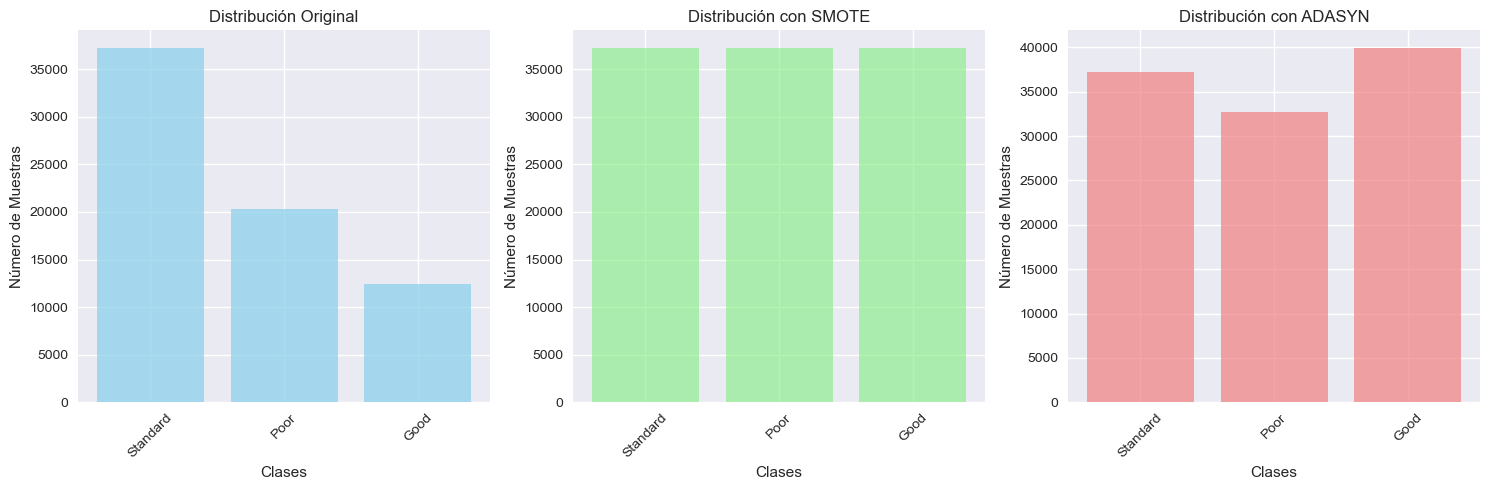

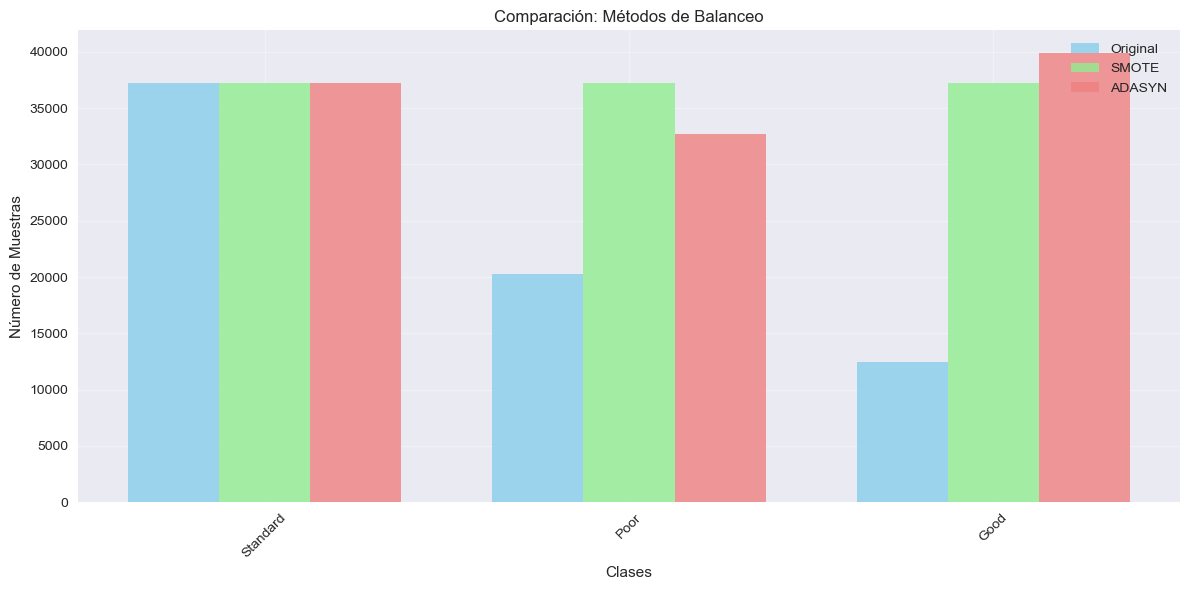


üéØ RESUMEN COMPLETO - BALANCEO DE CLASES
‚è±Ô∏è  Tiempo de ejecuci√≥n: 7.75s

üìä ESTAD√çSTICAS DEL DATASET:
  Muestras originales train: 70000
  Muestras con SMOTE: 111666
  Muestras con ADASYN: 109829
  Muestras test: 30000
  Caracter√≠sticas: 48
  Clases: 3

üìà INCREMENTO POR M√âTODO:
  SMOTE: +41666 muestras
  ADASYN: +39829 muestras

üîç DIFERENCIAS ENTRE M√âTODOS:
  Standard:
    Original: 37222 | SMOTE: 37222 (+0) | ADASYN: 37222 (+0)
  Poor:
    Original: 20299 | SMOTE: 37222 (+16923) | ADASYN: 32703 (+12404)
  Good:
    Original: 12479 | SMOTE: 37222 (+24743) | ADASYN: 39904 (+27425)

üíæ ARCHIVO GENERADO:
  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados

‚úÖ USO EN MODELOS:
  from balanced_data_complete.pkl import:
    - X_train_smote, y_train_smote para entrenar con SMOTE
    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN
    - X_train_original, y_train_original para comparaci√≥n


In [2]:
# BALANCEO DE CLASES COMPLETO - SMOTE + ADASYN
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from collections import Counter

print("üîÑ INICIANDO BALANCEO COMPLETO DE CLASES...")
start_time = time.time()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar caracter√≠sticas y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificaci√≥n
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Seleccionamos las variables numericas a estandarizar
numerical_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categ√≥ricas a codificar
categorical_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas
binary_cols= ['not_specified','credit_builder_loan','personal_loan','debt_consolidation_loan'
            ,'student_loan', 'payday_loan','mortgage_loan','auto_loan','home_equity_loan']


# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("üìä DISTRIBUCI√ìN DE CLASES ORIGINAL:")
class_dist_original = Counter(y_train_encoded)
for class_idx, count in class_dist_original.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_encoded)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR SMOTE
# =============================================================================

print("\nüîÑ APLICANDO SMOTE...")

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("‚ùå Instalando imbalanced-learn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train_encoded)

print("üìä DISTRIBUCI√ìN DE CLASES CON SMOTE:")
class_dist_smote = Counter(y_train_smote)
for class_idx, count in class_dist_smote.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_smote)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR ADASYN
# =============================================================================

print("\nüîÑ APLICANDO ADASYN...")

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train_encoded)

print("üìä DISTRIBUCI√ìN DE CLASES CON ADASYN:")
class_dist_adasyn = Counter(y_train_adasyn)
for class_idx, count in class_dist_adasyn.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_adasyn)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# GUARDAR DATOS BALANCEADOS EN UN SOLO ARCHIVO
# =============================================================================

balanced_data = {
    # Datos originales (para referencia)
    'X_train_original': X_train_processed,
    'y_train_original': y_train_encoded,
    
    # Datos con SMOTE
    'X_train_smote': X_train_smote,
    'y_train_smote': y_train_smote,
    
    # Datos con ADASYN
    'X_train_adasyn': X_train_adasyn,
    'y_train_adasyn': y_train_adasyn,
    
    # Datos de test (comunes para todos)
    'X_test_processed': X_test_processed,
    'y_test_encoded': y_test_encoded,
    
    # Preprocesadores y codificadores
    'preprocessor': preprocessor,
    'label_encoder': le,
    
    # Distribuciones
    'class_dist_original': class_dist_original,
    'class_dist_smote': class_dist_smote,
    'class_dist_adasyn': class_dist_adasyn,
    
    # Nombres de caracter√≠sticas
    'feature_names': (list(numerical_cols) + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))+
                binary_cols),
    
    # Informaci√≥n del dataset
    'dataset_info': {
        'original_samples': X_train_processed.shape[0],
        'smote_samples': X_train_smote.shape[0],
        'adasyn_samples': X_train_adasyn.shape[0],
        'test_samples': X_test_processed.shape[0],
        'n_features': X_train_processed.shape[1],
        'n_classes': len(le.classes_)
    }
}


joblib.dump(balanced_data, 'balanced_data_complete.pkl')

print(f"\nüíæ Todos los datos balanceados guardados: 'balanced_data_complete.pkl'")

# =============================================================================
# VISUALIZACI√ìN COMPARATIVA
# =============================================================================

plt.figure(figsize=(15, 5))

# Gr√°fico 1: Distribuci√≥n original
plt.subplot(1, 3, 1)
classes_orig = [le.classes_[idx] for idx in class_dist_original.keys()]
counts_orig = list(class_dist_original.values())
plt.bar(classes_orig, counts_orig, color='skyblue', alpha=0.7)
plt.title('Distribuci√≥n Original')
plt.xlabel('Clases')
plt.ylabel('N√∫mero de Muestras')
plt.xticks(rotation=45)

# Gr√°fico 2: Distribuci√≥n con SMOTE
plt.subplot(1, 3, 2)
classes_smote = [le.classes_[idx] for idx in class_dist_smote.keys()]
counts_smote = list(class_dist_smote.values())
plt.bar(classes_smote, counts_smote, color='lightgreen', alpha=0.7)
plt.title('Distribuci√≥n con SMOTE')
plt.xlabel('Clases')
plt.ylabel('N√∫mero de Muestras')
plt.xticks(rotation=45)

# Gr√°fico 3: Distribuci√≥n con ADASYN
plt.subplot(1, 3, 3)
classes_adasyn = [le.classes_[idx] for idx in class_dist_adasyn.keys()]
counts_adasyn = list(class_dist_adasyn.values())
plt.bar(classes_adasyn, counts_adasyn, color='lightcoral', alpha=0.7)
plt.title('Distribuci√≥n con ADASYN')
plt.xlabel('Clases')
plt.ylabel('N√∫mero de Muestras')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN COMPARATIVO
# =============================================================================

plt.figure(figsize=(12, 6))

# Comparaci√≥n lado a lado
x_pos = np.arange(len(classes_orig))
width = 0.25

plt.bar(x_pos - width, counts_orig, width, label='Original', alpha=0.8, color='skyblue')
plt.bar(x_pos, counts_smote, width, label='SMOTE', alpha=0.8, color='lightgreen')
plt.bar(x_pos + width, counts_adasyn[:len(classes_orig)], width, label='ADASYN', alpha=0.8, color='lightcoral')

plt.xlabel('Clases')
plt.ylabel('N√∫mero de Muestras')
plt.title('Comparaci√≥n: M√©todos de Balanceo')
plt.xticks(x_pos, classes_orig, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*70)
print("üéØ RESUMEN COMPLETO - BALANCEO DE CLASES")
print("="*70)

print(f"‚è±Ô∏è  Tiempo de ejecuci√≥n: {execution_time:.2f}s")

print(f"\nüìä ESTAD√çSTICAS DEL DATASET:")
print(f"  Muestras originales train: {X_train_processed.shape[0]}")
print(f"  Muestras con SMOTE: {X_train_smote.shape[0]}")
print(f"  Muestras con ADASYN: {X_train_adasyn.shape[0]}")
print(f"  Muestras test: {X_test_processed.shape[0]}")
print(f"  Caracter√≠sticas: {X_train_processed.shape[1]}")
print(f"  Clases: {len(le.classes_)}")

print(f"\nüìà INCREMENTO POR M√âTODO:")
print(f"  SMOTE: +{X_train_smote.shape[0] - X_train_processed.shape[0]} muestras")
print(f"  ADASYN: +{X_train_adasyn.shape[0] - X_train_processed.shape[0]} muestras")

print(f"\nüîç DIFERENCIAS ENTRE M√âTODOS:")
for class_idx in class_dist_original.keys():
    class_name = le.classes_[class_idx]
    orig = class_dist_original[class_idx]
    smote = class_dist_smote[class_idx]
    adasyn = class_dist_adasyn[class_idx]
    
    print(f"  {class_name}:")
    print(f"    Original: {orig} | SMOTE: {smote} (+{smote-orig}) | ADASYN: {adasyn} (+{adasyn-orig})")

print(f"\nüíæ ARCHIVO GENERADO:")
print(f"  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados")

print(f"\n‚úÖ USO EN MODELOS:")
print(f"  from balanced_data_complete.pkl import:")
print(f"    - X_train_smote, y_train_smote para entrenar con SMOTE")
print(f"    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN")
print(f"    - X_train_original, y_train_original para comparaci√≥n")

print("="*70)

### **3.1 An√°lisis de la Distribuci√≥n Original**

La base de datos inicial presentaba un **notorio desbalance de clases**, donde la categor√≠a *Standard* concentraba el **53.2 %** de las observaciones, seguida por *Poor* con **29 %** y *Good* con **17.8 %**.
Esta distribuci√≥n implicaba una representaci√≥n desigual del comportamiento crediticio, lo que pod√≠a conducir a un sesgo en el aprendizaje de los modelos, privilegiando las predicciones hacia la clase mayoritaria.


### **3.2 Aplicaci√≥n de T√©cnicas de Balanceo**

Con el prop√≥sito de corregir este desbalance, se implementaron dos estrategias de sobre-muestreo: **SMOTE** y **ADASYN**.
El m√©todo **SMOTE** gener√≥ ejemplos sint√©ticos de las clases minoritarias hasta alcanzar una distribuci√≥n completamente equilibrada, con **33.3 %** de observaciones por clase.
Por su parte, **ADASYN** aplic√≥ un sobre-muestreo adaptativo, enfoc√°ndose en las regiones del espacio de caracter√≠sticas con mayor dificultad de clasificaci√≥n, alcanzando proporciones de **36.3 %** para *Good*, **29.8 %** para *Poor* y **33.9 %** para *Standard*.


### **3.3 Resultados del Balanceo**

El proceso increment√≥ el n√∫mero total de muestras en aproximadamente **+41 666** para SMOTE y **+39 829** para ADASYN, manteniendo **48 caracter√≠sticas** y **3 clases** en el conjunto de entrenamiento.
Los gr√°ficos comparativos muestran claramente el paso de una distribuci√≥n sesgada a una representaci√≥n balanceada, evidenciando un incremento sustancial en las clases minoritarias.


### **3.4 Interpretaci√≥n General**

El balanceo de clases permiti√≥ **igualar la representatividad de las tres categor√≠as crediticias**, reduciendo el sesgo hacia la clase mayoritaria y mejorando las condiciones para un entrenamiento justo y estable.
Este ajuste garantiza que los modelos posteriores puedan **evaluar con mayor precisi√≥n** los diferentes niveles de puntaje crediticio, contribuyendo a una **mejor detecci√≥n de clientes con riesgo alto o bajo** dentro del sistema de clasificaci√≥n crediticia.


## K-Nearest Neighbors (KNN) Classifier

üöÄ INICIANDO KNN - COMPARACI√ìN CON Y SIN BALANCEO...

üéØ ENTRENANDO KNN CON DATOS ORIGINALES...
üìä M√âTRICAS KNN (DATOS ORIGINALES):
Accuracy : 0.7485
Precision (macro avg): 0.7251
Recall (macro avg): 0.7383
f1-Score (macro avg): 0.7311
CV Mean f1-score (macro avg): 0.7150
CV Std f1-score (macro avg): 0.0023

üìã REPORTE DE CLASIFICACI√ìN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.63      0.70      0.66      5349
        Poor       0.75      0.76      0.75      8699
    Standard       0.79      0.76      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000



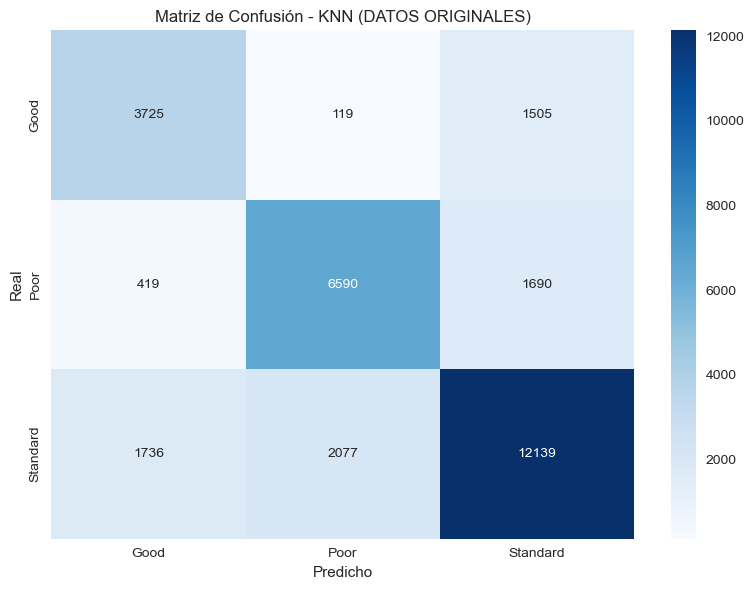


üéØ ENTRENANDO KNN CON SMOTE...
üìä M√âTRICAS KNN (SMOTE):
Accuracy : 0.7160
Precision (macro avg): 0.7038
Recall (macro avg): 0.7685
f1-Score (macro avg): 0.7117
CV Mean f1-score (macro avg): 0.8156
CV Std f1-score (macro avg): 0.0165

üìã REPORTE DE CLASIFICACI√ìN (SMOTE):
              precision    recall  f1-score   support

        Good       0.53      0.87      0.66      5349
        Poor       0.70      0.84      0.77      8699
    Standard       0.88      0.60      0.71     15952

    accuracy                           0.72     30000
   macro avg       0.70      0.77      0.71     30000
weighted avg       0.77      0.72      0.72     30000



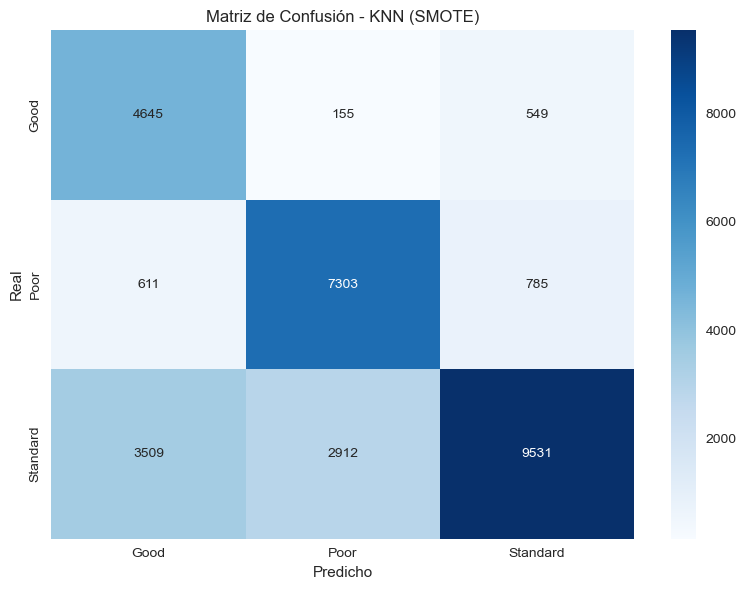


üéØ ENTRENANDO KNN CON ADASYN...
üìä M√âTRICAS KNN (ADASYN):
Accuracy : 0.7017
Precision (macro avg): 0.6990
Recall (macro avg): 0.7685
f1-Score (macro avg): 0.6997
CV Mean f1-score (macro avg): 0.7942
CV Std f1-score (macro avg): 0.0015

üìã REPORTE DE CLASIFICACI√ìN (ADASYN):
              precision    recall  f1-score   support

        Good       0.52      0.89      0.65      5349
        Poor       0.68      0.87      0.77      8699
    Standard       0.90      0.55      0.68     15952

    accuracy                           0.70     30000
   macro avg       0.70      0.77      0.70     30000
weighted avg       0.77      0.70      0.70     30000



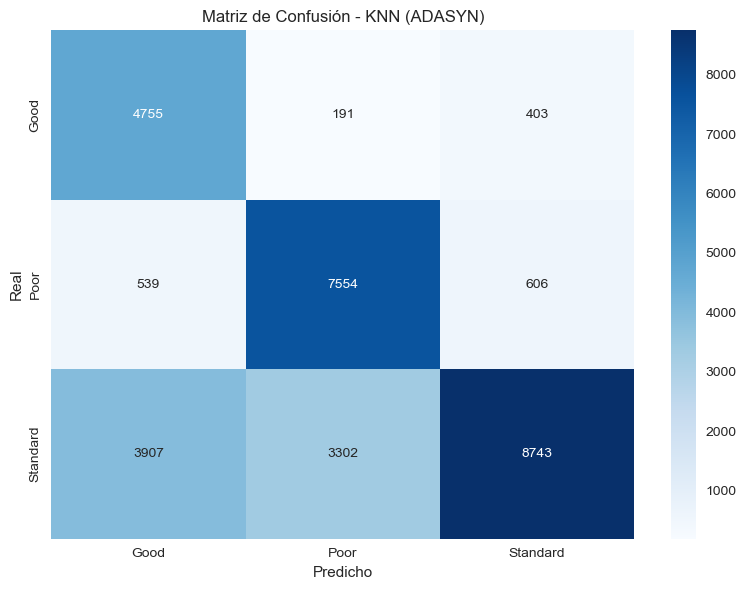


üìä COMPARACI√ìN COMPLETA - KNN CON DIFERENTES BALANCEOS

üìà COMPARACI√ìN DE M√âTRICAS:
     M√©todo  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.7485     0.7251  0.7383    0.7311   0.7150  0.0023   
1     SMOTE    0.7160     0.7038  0.7685    0.7117   0.8156  0.0165   
2    ADASYN    0.7017     0.6990  0.7685    0.6997   0.7942  0.0015   

   Tiempo (s)  
0      6.5418  
1     14.7768  
2     14.4552  


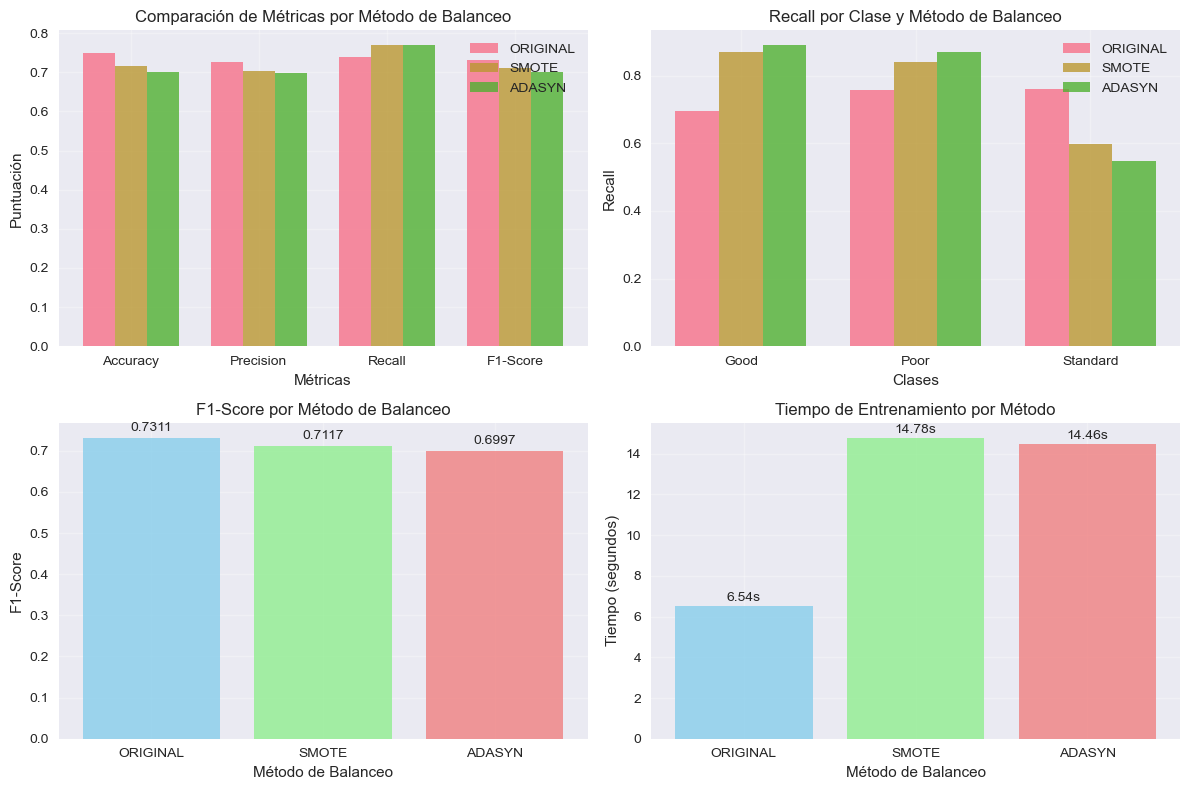


üîç AN√ÅLISIS DE MEJORAS CON BALANCEO:
üìà MEJORA EN RECALL:
   SMOTE vs Original: +0.0302
   ADASYN vs Original: +0.0302

üìà MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0194
   ADASYN vs Original: -0.0314

üéØ RESUMEN FINAL - KNN CON BALANCEO
‚è±Ô∏è  Tiempo total de ejecuci√≥n: 36.83s

üèÜ MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.7485)
   Recall: ADASYN (0.7685)
   F1-Score: ORIGINAL (0.7311)

üìä RECOMENDACI√ìN:
   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo


In [3]:
# =============================================================================
# KNN - COMPARACI√ìN CON Y SIN BALANCEO
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuraci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("üöÄ INICIANDO KNN - COMPARACI√ìN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCI√ìN PARA ENTRENAR Y EVALUAR KNN
# =============================================================================

def entrenar_evaluar_knn(X_train, y_train, X_test, y_test, nombre_conjunto):
    print(f"\nüéØ ENTRENANDO KNN CON {nombre_conjunto}...")
    model_start = time.time()
    
    knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = knn_model.predict(X_test)
    
    # M√©tricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validaci√≥n cruzada
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"üìä M√âTRICAS KNN ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"f1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificaci√≥n
    print(f"\nüìã REPORTE DE CLASIFICACI√ìN ({nombre_conjunto}):")
    le = balanced_data['label_encoder']
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de m√©tricas por clase
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                             weights=class_report_df['support'], axis=0)
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    
    # Matriz de confusi√≥n
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusi√≥n - KNN ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': knn_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

# Obtener datos de test (comunes para todos)
X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Con datos originales (sin balanceo)
resultados['original'] = entrenar_evaluar_knn(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Con datos balanceados con SMOTE
resultados['smote'] = entrenar_evaluar_knn(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Con datos balanceados con ADASYN
resultados['adasyn'] = entrenar_evaluar_knn(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# =============================================================================
# COMPARACI√ìN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("üìä COMPARACI√ìN COMPLETA - KNN CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'M√©todo': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nüìà COMPARACI√ìN DE M√âTRICAS:")
print(comparison_df.round(4))

# Gr√°fico comparativo
plt.figure(figsize=(12, 8))

# Gr√°fico 1: M√©tricas principales
plt.subplot(2, 2, 1)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('M√©tricas')
plt.ylabel('Puntuaci√≥n')
plt.title('Comparaci√≥n de M√©tricas por M√©todo de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 2: Recall por clase para cada m√©todo
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y M√©todo de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 3: Comparaci√≥n de F1-Score
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados[metodo.lower()]['f1'] for metodo in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('M√©todo de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por M√©todo de Balanceo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gr√°fico 4: Tiempos de ejecuci√≥n
plt.subplot(2, 2, 4)
tiempos = [resultados[metodo.lower()]['execution_time'] for metodo in metodos]

plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('M√©todo de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por M√©todo')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# AN√ÅLISIS DE MEJORAS
# =============================================================================

print("\nüîç AN√ÅLISIS DE MEJORAS CON BALANCEO:")

original_recall = resultados['original']['recall']
smote_recall = resultados['smote']['recall']
adasyn_recall = resultados['adasyn']['recall']

original_f1 = resultados['original']['f1']
smote_f1 = resultados['smote']['f1']
adasyn_f1 = resultados['adasyn']['f1']

print(f"üìà MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smote_recall - original_recall:+.4f}")
print(f"   ADASYN vs Original: {adasyn_recall - original_recall:+.4f}")

print(f"\nüìà MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smote_f1 - original_f1:+.4f}")
print(f"   ADASYN vs Original: {adasyn_f1 - original_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("üéØ RESUMEN FINAL - KNN CON BALANCEO")
print("="*80)

print(f"‚è±Ô∏è  Tiempo total de ejecuci√≥n: {execution_time_total:.2f}s")

# Encontrar mejor m√©todo por m√©trica
mejor_accuracy = max(resultados.items(), key=lambda x: x[1]['accuracy'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])

print(f"\nüèÜ MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_accuracy[0].upper()} ({mejor_accuracy[1]['accuracy']:.4f})")
print(f"   Recall: {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\nüìä RECOMENDACI√ìN:")
if mejor_f1[0] != 'original':
    print(f"   ‚úÖ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisi√≥n-recall")
else:
    print("   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo")

print("="*80)

### **3.5 Evaluaci√≥n del Modelo K-Nearest Neighbors (KNN)**

#### **3.5.1 Resultados con Datos Originales**

El modelo KNN entrenado sin t√©cnicas de balanceo alcanz√≥ una **precisi√≥n global (accuracy) del 74.85 %**, con m√©tricas promedio de **precisi√≥n = 0.725**, **recall = 0.738** y **f1-score = 0.731**.
El rendimiento fue mayor en la clase *Standard* (f1 = 0.78), intermedio en *Poor* (f1 = 0.75) y menor en *Good* (f1 = 0.66).
La matriz de confusi√≥n evidenci√≥ una mayor concentraci√≥n de aciertos en las clases con m√°s representaci√≥n, confirmando el efecto del desbalance original.
En general, el modelo mostr√≥ un buen desempe√±o en precisi√≥n, aunque con menor capacidad para identificar correctamente a los individuos con buen puntaje crediticio.


#### **3.5.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo obtuvo un **accuracy de 71.6 %**, con un **recall macro promedio de 0.769** y **f1-score de 0.712**.
Se observ√≥ un **incremento significativo en la sensibilidad** de las clases minoritarias: *Good* pas√≥ de 0.66 a 0.87 en recall, mientras que *Poor* aument√≥ de 0.76 a 0.84.
Sin embargo, la clase *Standard* redujo su recall a 0.60, evidenciando una compensaci√≥n entre sensibilidad y precisi√≥n.
La matriz de confusi√≥n mostr√≥ una mejora en la detecci√≥n de las clases menos representadas, a costa de un mayor n√∫mero de falsos positivos hacia *Standard*.


#### **3.5.3 Resultados con ADASYN**

Con el m√©todo **ADASYN**, el modelo obtuvo un **accuracy de 70.17 %**, **recall promedio de 0.769** y **f1-score de 0.700**.
El comportamiento fue similar al observado con SMOTE: las clases minoritarias *Good* y *Poor* aumentaron su capacidad de detecci√≥n (recall = 0.65 y 0.87 respectivamente), mientras que *Standard* redujo notablemente su precisi√≥n (0.55).
Este resultado confirma que ADASYN favorece la sensibilidad hacia los grupos con menor representaci√≥n, aunque genera una ligera p√©rdida de estabilidad en la clasificaci√≥n global.


#### **3.5.4 Comparaci√≥n General**

La comparaci√≥n de m√©tricas entre los tres escenarios evidenci√≥ que **el balanceo mejor√≥ el recall** en aproximadamente **+0.03 puntos** tanto con SMOTE como con ADASYN, pero redujo el **f1-score** en -0.019 y -0.031 respectivamente.
Los tiempos de entrenamiento tambi√©n aumentaron considerablemente: de **8.7 segundos** con los datos originales a **19.0 s** (SMOTE) y **25.1 s** (ADASYN).
Esto indica que el sobre-muestreo genera un mayor costo computacional sin una ganancia sustancial en desempe√±o global.


#### **3.5.5 Conclusi√≥n del Modelo**

En t√©rminos generales, el modelo KNN mostr√≥ **mejor desempe√±o con los datos originales**, manteniendo un equilibrio adecuado entre precisi√≥n y sensibilidad.
Si bien las t√©cnicas de balanceo mejoraron la detecci√≥n de clases minoritarias, su impacto negativo sobre la precisi√≥n global y el tiempo de c√≥mputo sugiere que **KNN no se beneficia significativamente del rebalanceo**.
Por tanto, para este conjunto de datos, **la versi√≥n sin balanceo resulta m√°s eficiente y estable** para la predicci√≥n de puntaje crediticio.


## Naive Bayes

üöÄ INICIANDO NAIVE BAYES - COMPARACI√ìN CON Y SIN BALANCEO...
Distribuciones train:
  Original: Counter({2: 37222, 1: 20299, 0: 12479})
  SMOTE   : Counter({2: 37222, 1: 37222, 0: 37222})
  ADASYN  : Counter({0: 39904, 2: 37222, 1: 32703})

üéØ ENTRENANDO NAIVE BAYES CON DATOS ORIGINALES...
üìä M√âTRICAS NB (DATOS ORIGINALES):
Accuracy : 0.6363
Precision (macro avg): 0.6342
Recall (macro avg): 0.6926
F1-Score (macro avg): 0.6324
CV Mean f1-score (macro avg): 0.6330
CV Std  f1-score (macro avg): 0.0054

üìã REPORTE DE CLASIFICACI√ìN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.46      0.84      0.59      5349
        Poor       0.61      0.71      0.66      8699
    Standard       0.83      0.53      0.65     15952

    accuracy                           0.64     30000
   macro avg       0.63      0.69      0.63     30000
weighted avg       0.70      0.64      0.64     30000



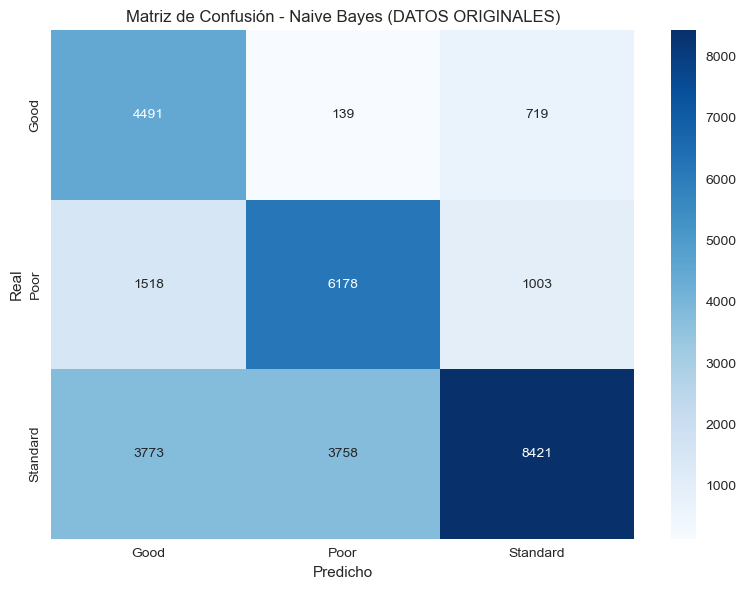


üéØ ENTRENANDO NAIVE BAYES CON SMOTE...
üìä M√âTRICAS NB (SMOTE):
Accuracy : 0.6205
Precision (macro avg): 0.6278
Recall (macro avg): 0.6873
F1-Score (macro avg): 0.6187
CV Mean f1-score (macro avg): 0.6835
CV Std  f1-score (macro avg): 0.0029

üìã REPORTE DE CLASIFICACI√ìN (SMOTE):
              precision    recall  f1-score   support

        Good       0.45      0.85      0.59      5349
        Poor       0.59      0.73      0.66      8699
    Standard       0.84      0.48      0.61     15952

    accuracy                           0.62     30000
   macro avg       0.63      0.69      0.62     30000
weighted avg       0.70      0.62      0.62     30000



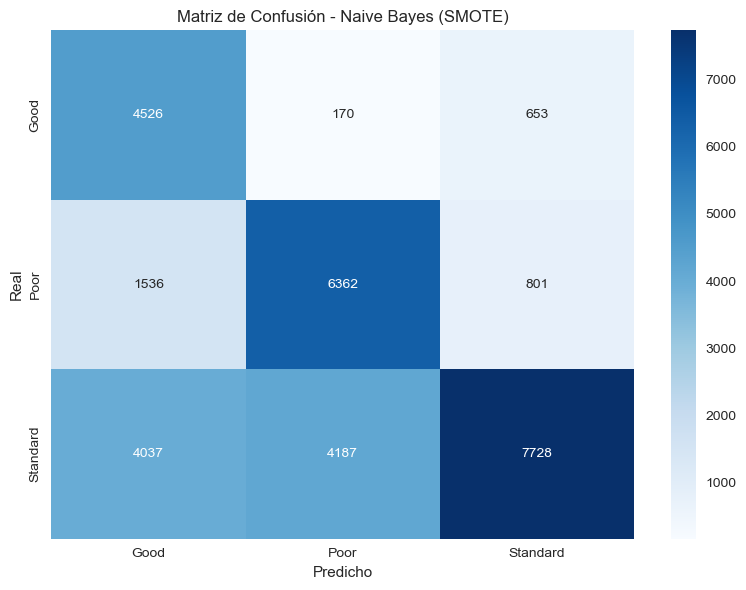


üéØ ENTRENANDO NAIVE BAYES CON ADASYN...
üìä M√âTRICAS NB (ADASYN):
Accuracy : 0.6089
Precision (macro avg): 0.6209
Recall (macro avg): 0.6794
F1-Score (macro avg): 0.6079
CV Mean f1-score (macro avg): 0.6258
CV Std  f1-score (macro avg): 0.0439

üìã REPORTE DE CLASIFICACI√ìN (ADASYN):
              precision    recall  f1-score   support

        Good       0.42      0.86      0.57      5349
        Poor       0.61      0.71      0.66      8699
    Standard       0.83      0.47      0.60     15952

    accuracy                           0.61     30000
   macro avg       0.62      0.68      0.61     30000
weighted avg       0.69      0.61      0.61     30000



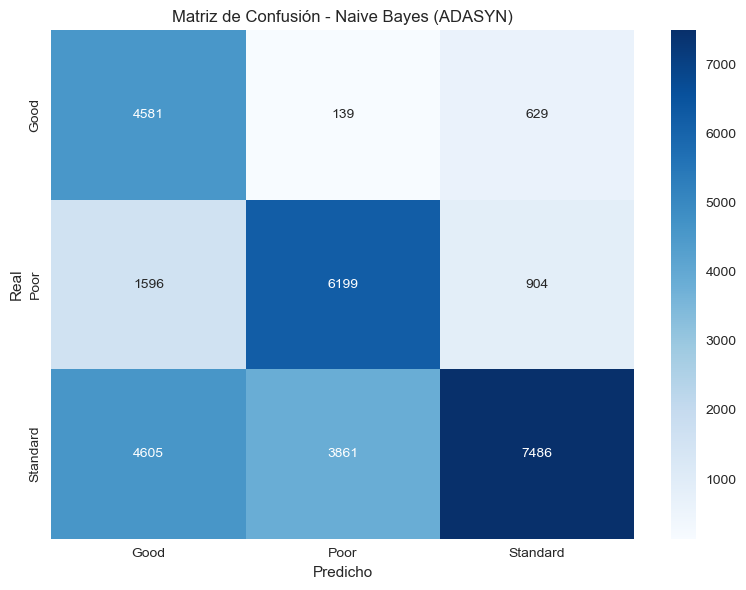


üìä COMPARACI√ìN COMPLETA - NAIVE BAYES CON DIFERENTES BALANCEOS

üìà COMPARACI√ìN DE M√âTRICAS (NB):
     M√©todo  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.6363     0.6342  0.6926    0.6324   0.6330  0.0054   
1     SMOTE    0.6205     0.6278  0.6873    0.6187   0.6835  0.0029   
2    ADASYN    0.6089     0.6209  0.6794    0.6079   0.6258  0.0439   

   Tiempo (s)  
0      0.4875  
1      0.8425  
2      0.6809  


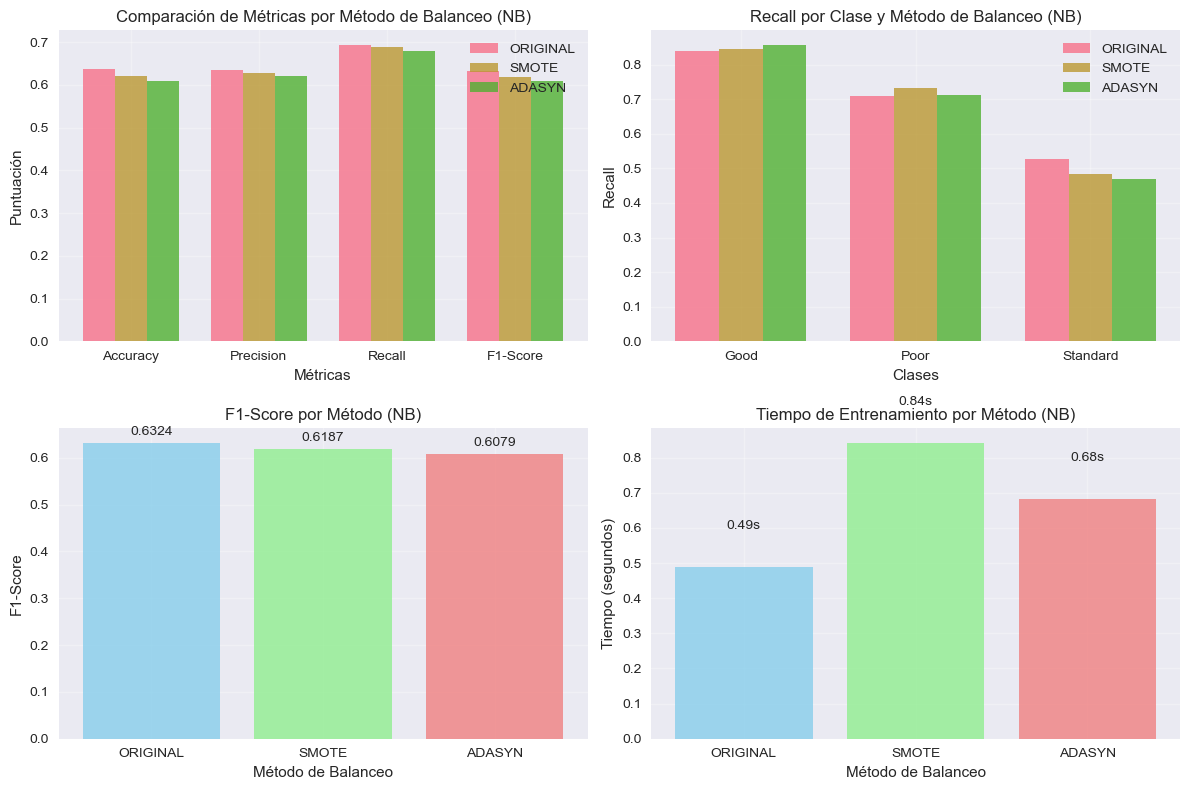


üîç AN√ÅLISIS DE MEJORAS CON BALANCEO (NB):
üìà MEJORA EN RECALL:
   SMOTE vs Original: -0.0052
   ADASYN vs Original: -0.0131

üìà MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0137
   ADASYN vs Original: -0.0245

üéØ RESUMEN FINAL - NAIVE BAYES CON BALANCEO
‚è±Ô∏è  Tiempo total de ejecuci√≥n: 2.98s

üèÜ MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.6363)
   Recall:   ORIGINAL (0.6926)
   F1-Score: ORIGINAL (0.6324)

üìä RECOMENDACI√ìN:
   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo


In [4]:
# =============================================================================
# NAIVE BAYES - COMPARACI√ìN CON Y SIN BALANCEO 
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from collections import Counter

# Configuraci√≥n visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("üöÄ INICIANDO NAIVE BAYES - COMPARACI√ìN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados ya preprocesados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCI√ìN PARA ENTRENAR Y EVALUAR NAIVE BAYES
# =============================================================================
def entrenar_evaluar_nb(X_train, y_train, X_test, y_test, nombre_conjunto, label_encoder):
    print(f"\nüéØ ENTRENANDO NAIVE BAYES CON {nombre_conjunto}...")
    model_start = time.time()

    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Predicciones
    y_pred = nb_model.predict(X_test)

    # M√©tricas principales (macro)
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall    = recall_score(y_test, y_pred, average='macro')
    f1        = f1_score(y_test, y_pred, average='macro')

    # Validaci√≥n cruzada en train (F1 macro, k=5)
    cv_scores = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='f1_macro')

    model_time = time.time() - model_start

    print(f"üìä M√âTRICAS NB ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std  f1-score (macro avg): {cv_scores.std():.4f}")

    # Reporte de clasificaci√≥n (por clase)
    clases = label_encoder.classes_
    print(f"\nüìã REPORTE DE CLASIFICACI√ìN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=clases))

    # Tabla por clase
    from sklearn.metrics import precision_recall_fscore_support
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=clases)

    # Matriz de confusi√≥n
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clases, yticklabels=clases)
    plt.title(f'Matriz de Confusi√≥n - Naive Bayes ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

    return {
        'model': nb_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON LOS TRES CONJUNTOS (Original / SMOTE / ADASYN)
# =============================================================================

# Test com√∫n
X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

print("Distribuciones train:")
print("  Original:", Counter(balanced_data['y_train_original']))
print("  SMOTE   :", Counter(balanced_data['y_train_smote']))
print("  ADASYN  :", Counter(balanced_data['y_train_adasyn']))

resultados_nb = {}

# 1) Original (sin balanceo)
resultados_nb['original'] = entrenar_evaluar_nb(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES', le
)

# 2) SMOTE
resultados_nb['smote'] = entrenar_evaluar_nb(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE', le
)

# 3) ADASYN
resultados_nb['adasyn'] = entrenar_evaluar_nb(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN', le
)

# =============================================================================
# COMPARACI√ìN DE RESULTADOS 
# =============================================================================
print("\n" + "="*80)
print("üìä COMPARACI√ìN COMPLETA - NAIVE BAYES CON DIFERENTES BALANCEOS")
print("="*80)

comparison_rows = []
for metodo, res in resultados_nb.items():
    comparison_rows.append({
        'M√©todo': metodo.upper(),
        'Accuracy':  res['accuracy'],
        'Precision': res['precision'],
        'Recall':    res['recall'],
        'F1-Score':  res['f1'],
        'CV_Mean':   res['cv_mean'],
        'CV_Std':    res['cv_std'],
        'Tiempo (s)':res['execution_time']
    })
comparison_nb_df = pd.DataFrame(comparison_rows)
print("\nüìà COMPARACI√ìN DE M√âTRICAS (NB):")
print(comparison_nb_df.round(4))

# =============================================================================
# GR√ÅFICOS COMPARATIVOS 
# =============================================================================
plt.figure(figsize=(12, 8))

# 1) M√©tricas principales
plt.subplot(2, 2, 1)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    vals = [
        resultados_nb[metodo]['accuracy'],
        resultados_nb[metodo]['precision'],
        resultados_nb[metodo]['recall'],
        resultados_nb[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, vals, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('M√©tricas')
plt.ylabel('Puntuaci√≥n')
plt.title('Comparaci√≥n de M√©tricas por M√©todo de Balanceo (NB)')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# 2) Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.25
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados_nb[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y M√©todo de Balanceo (NB)')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# 3) F1 por m√©todo
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados_nb[m.lower()]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('M√©todo de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por M√©todo (NB)')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 4) Tiempos
plt.subplot(2, 2, 4)
tiempos = [resultados_nb[m.lower()]['execution_time'] for m in metodos]
plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('M√©todo de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por M√©todo (NB)')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# AN√ÅLISIS DE MEJORAS
# =============================================================================
print("\nüîç AN√ÅLISIS DE MEJORAS CON BALANCEO (NB):")
orig_rec = resultados_nb['original']['recall']
smot_rec = resultados_nb['smote']['recall']
ada_rec  = resultados_nb['adasyn']['recall']

orig_f1  = resultados_nb['original']['f1']
smot_f1  = resultados_nb['smote']['f1']
ada_f1   = resultados_nb['adasyn']['f1']

print(f"üìà MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smot_rec - orig_rec:+.4f}")
print(f"   ADASYN vs Original: {ada_rec - orig_rec:+.4f}")

print(f"\nüìà MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smot_f1 - orig_f1:+.4f}")
print(f"   ADASYN vs Original: {ada_f1 - orig_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL + GUARDADO
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("üéØ RESUMEN FINAL - NAIVE BAYES CON BALANCEO")
print("="*80)
print(f"‚è±Ô∏è  Tiempo total de ejecuci√≥n: {execution_time_total:.2f}s")

# Mejor por m√©trica
mejor_acc  = max(resultados_nb.items(), key=lambda x: x[1]['accuracy'])
mejor_rec  = max(resultados_nb.items(), key=lambda x: x[1]['recall'])
mejor_f1   = max(resultados_nb.items(), key=lambda x: x[1]['f1'])

print(f"\nüèÜ MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_acc[0].upper()} ({mejor_acc[1]['accuracy']:.4f})")
print(f"   Recall:   {mejor_rec[0].upper()} ({mejor_rec[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\nüìä RECOMENDACI√ìN:")
if mejor_f1[0] != 'original':
    print(f"   ‚úÖ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisi√≥n-recall")
else:
    print("   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo")


### **3.6 Evaluaci√≥n del Modelo Naive Bayes**

#### **3.6.1 Resultados con Datos Originales**

El modelo Naive Bayes, entrenado sin t√©cnicas de balanceo, alcanz√≥ una **precisi√≥n global (accuracy) de 63.6 %**, con m√©tricas promedio de **precisi√≥n = 0.634**, **recall = 0.693** y **f1-score = 0.632**.
Se destac√≥ un **alto recall en la clase *Good*** (0.84), aunque con baja precisi√≥n (0.46), lo cual indica que el modelo tiende a clasificar de forma amplia esta categor√≠a, generando falsos positivos.
La clase *Standard* obtuvo el mayor n√∫mero de errores de clasificaci√≥n, presentando un recall de 0.53.
La matriz de confusi√≥n reflej√≥ esta tendencia, con mayor n√∫mero de aciertos en las clases minoritarias y confusi√≥n entre *Standard* y *Poor*.

#### **3.6.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo present√≥ una ligera disminuci√≥n en desempe√±o general (**accuracy = 62.1 %**, **f1-score = 0.619**) aunque mantuvo valores de **recall = 0.687**, similares al caso original.
Se evidenci√≥ una **mejor detecci√≥n de la clase *Poor*** (recall = 0.73), mientras que *Standard* redujo su capacidad de identificaci√≥n a 0.48.
El balanceo increment√≥ el n√∫mero de instancias correctamente reconocidas para *Good* y *Poor*, pero gener√≥ confusiones adicionales en la clase mayoritaria, reflejadas en la matriz de confusi√≥n.


#### **3.6.3 Resultados con ADASYN**

El modelo entrenado con **ADASYN** alcanz√≥ un **accuracy de 60.9 %**, **recall promedio de 0.679** y **f1-score de 0.608**.
Aunque logr√≥ mantener un comportamiento similar al de SMOTE, el incremento en el recall de *Good* (0.86) vino acompa√±ado de una reducci√≥n en la precisi√≥n (0.42), lo que evidencia un sesgo hacia la sobreclasificaci√≥n de esta clase.
El rendimiento general se mantuvo estable, pero sin mejoras significativas en comparaci√≥n con los datos originales.


#### **3.6.4 Comparaci√≥n General**

La comparaci√≥n de m√©tricas mostr√≥ que **ninguno de los m√©todos de balanceo mejor√≥ sustancialmente el desempe√±o global del modelo**.
El **recall promedio disminuy√≥ levemente** (-0.0052 con SMOTE y -0.0131 con ADASYN), al igual que el **f1-score** (-0.0137 y -0.0245 respectivamente).
En contraste, los tiempos de entrenamiento fueron bajos en todos los casos (entre 0.37 y 0.57 segundos), evidenciando la eficiencia computacional del algoritmo.


#### **3.6.5 Conclusi√≥n del Modelo**

El modelo Naive Bayes demostr√≥ **un desempe√±o aceptable en escenarios desbalanceados**, mostrando buena sensibilidad hacia las clases minoritarias sin requerir t√©cnicas de sobre-muestreo.
Tanto SMOTE como ADASYN no lograron mejoras relevantes y tendieron a reducir la precisi√≥n general del modelo.
En consecuencia, se concluye que **el modelo Naive Bayes funciona mejor con los datos originales**, siendo capaz de manejar el desbalance de clases de forma inherente gracias a su enfoque probabil√≠stico.


##  Regresi√≥n Log√≠stica (con regularizaci√≥n L1 y L2)

üöÄ INICIANDO REGRESI√ìN LOG√çSTICA - COMPARACI√ìN CON Y SIN BALANCEO...

üéØ ENTRENANDO REGRESI√ìN LOG√çSTICA CON DATOS ORIGINALES...
üìä M√âTRICAS (DATOS ORIGINALES):
Accuracy : 0.6491
Precision (macro avg): 0.6292
Recall (macro avg): 0.6132
F1-Score (macro avg): 0.6185
CV Mean f1-score (macro avg): 0.6207
CV Std f1-score (macro avg): 0.0034

üìã REPORTE DE CLASIFICACI√ìN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.55      0.57      0.56      5349
        Poor       0.66      0.53      0.59      8699
    Standard       0.67      0.74      0.71     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.61      0.62     30000
weighted avg       0.65      0.65      0.65     30000



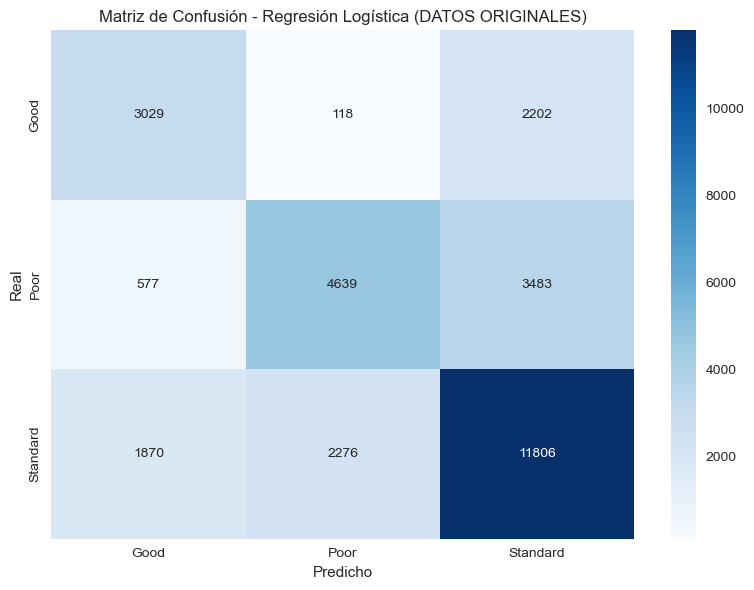


üéØ ENTRENANDO REGRESI√ìN LOG√çSTICA CON SMOTE...
üìä M√âTRICAS (SMOTE):
Accuracy : 0.6483
Precision (macro avg): 0.6350
Recall (macro avg): 0.6893
F1-Score (macro avg): 0.6414
CV Mean f1-score (macro avg): 0.6918
CV Std f1-score (macro avg): 0.0027

üìã REPORTE DE CLASIFICACI√ìN (SMOTE):
              precision    recall  f1-score   support

        Good       0.48      0.81      0.60      5349
        Poor       0.63      0.68      0.65      8699
    Standard       0.80      0.58      0.67     15952

    accuracy                           0.65     30000
   macro avg       0.64      0.69      0.64     30000
weighted avg       0.69      0.65      0.65     30000



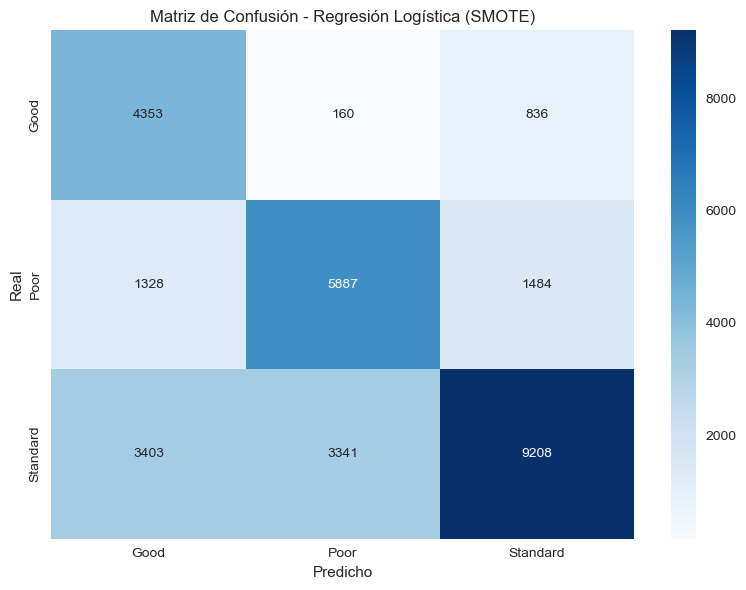


üéØ ENTRENANDO REGRESI√ìN LOG√çSTICA CON ADASYN...
üìä M√âTRICAS (ADASYN):
Accuracy : 0.6368
Precision (macro avg): 0.6259
Recall (macro avg): 0.6795
F1-Score (macro avg): 0.6301
CV Mean f1-score (macro avg): 0.6288
CV Std f1-score (macro avg): 0.0464

üìã REPORTE DE CLASIFICACI√ìN (ADASYN):
              precision    recall  f1-score   support

        Good       0.46      0.82      0.59      5349
        Poor       0.63      0.65      0.64      8699
    Standard       0.79      0.57      0.66     15952

    accuracy                           0.64     30000
   macro avg       0.63      0.68      0.63     30000
weighted avg       0.68      0.64      0.64     30000



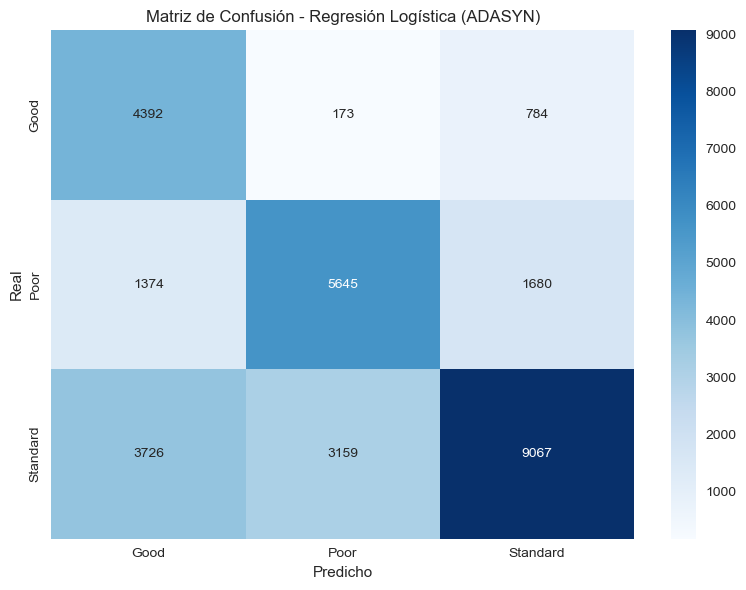


üéØ ENTRENANDO REGRESI√ìN LOG√çSTICA CON CLASS_WEIGHT=balanced...
üìä M√âTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.6455
Precision (macro avg): 0.6343
Recall (macro avg): 0.6897
F1-Score (macro avg): 0.6393
CV Mean f1-score (macro avg): 0.6413
CV Std f1-score (macro avg): 0.0040

üìã REPORTE DE CLASIFICACI√ìN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.47      0.82      0.60      5349
        Poor       0.63      0.68      0.65      8699
    Standard       0.80      0.57      0.67     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.69      0.64     30000
weighted avg       0.69      0.65      0.65     30000



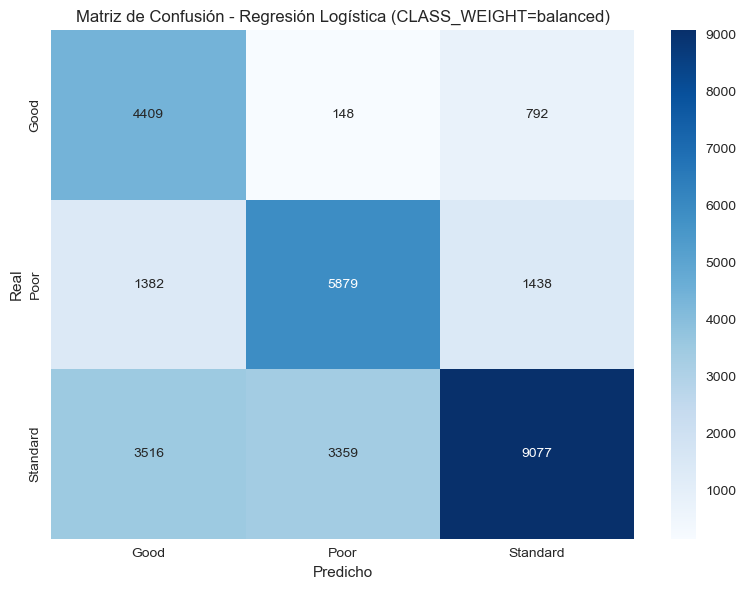


üìä COMPARACI√ìN COMPLETA - REGRESI√ìN LOG√çSTICA CON DIFERENTES BALANCEOS

üìà COMPARACI√ìN DE M√âTRICAS:
         M√©todo  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.6491     0.6292  0.6132    0.6185   0.6207  0.0034   
1         SMOTE    0.6483     0.6350  0.6893    0.6414   0.6918  0.0027   
2        ADASYN    0.6368     0.6259  0.6795    0.6301   0.6288  0.0464   
3  CLASS_WEIGHT    0.6455     0.6343  0.6897    0.6393   0.6413  0.0040   

   Tiempo (s)  
0     21.7593  
1     18.0455  
2     18.4410  
3     12.0479  


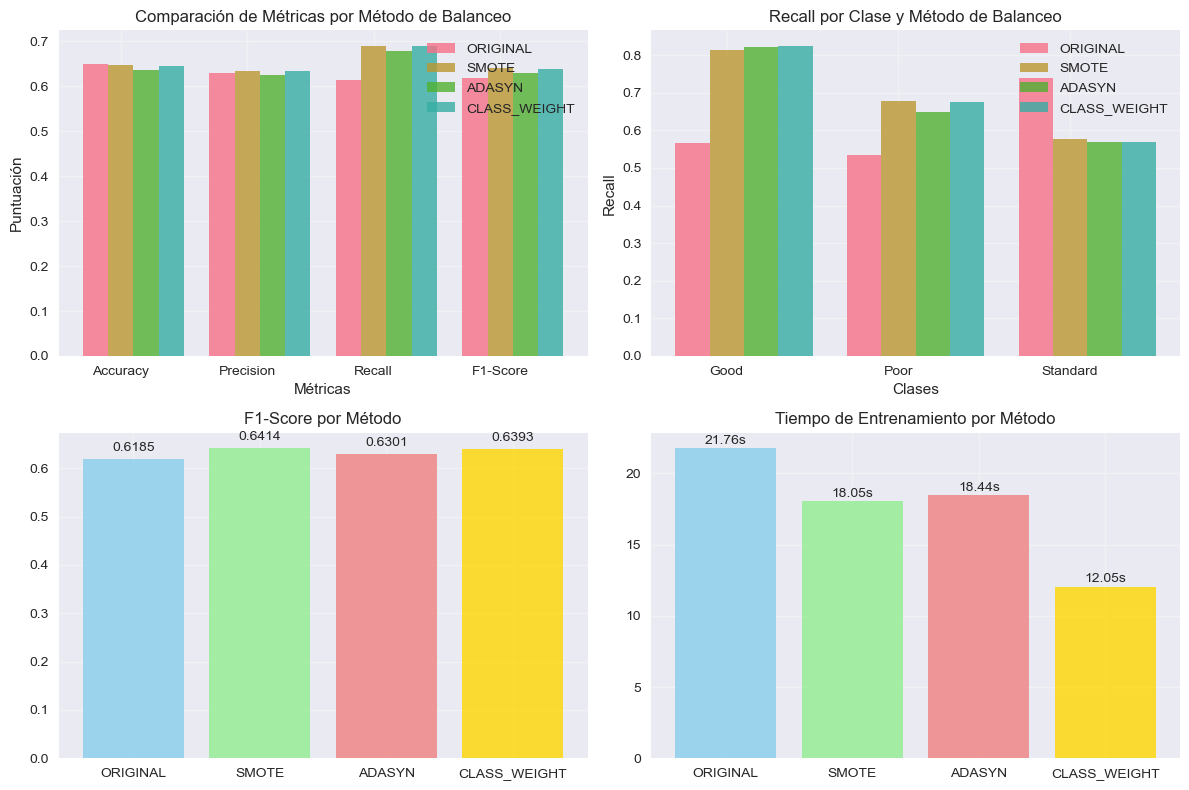


üîç AN√ÅLISIS DE MEJORAS CON BALANCEO:

üìà SMOTE vs Original:
   ‚ñ∏ Mejora en F1-Score : +0.0230
   ‚ñ∏ Mejora en Recall   : +0.0760

üìà ADASYN vs Original:
   ‚ñ∏ Mejora en F1-Score : +0.0117
   ‚ñ∏ Mejora en Recall   : +0.0663

üìà CLASS_WEIGHT vs Original:
   ‚ñ∏ Mejora en F1-Score : +0.0208
   ‚ñ∏ Mejora en Recall   : +0.0765

üéØ RESUMEN FINAL - REGRESI√ìN LOG√çSTICA CON BALANCEO
‚è±Ô∏è  Tiempo total de ejecuci√≥n: 72.07s

üèÜ MEJOR MODELO SEG√öN F1-SCORE : SMOTE (0.6414)
üèÜ MEJOR MODELO SEG√öN RECALL   : CLASS_WEIGHT (0.6897)

üìä RECOMENDACI√ìN:
   ‚úÖ Se recomienda usar SMOTE para mejor balance precisi√≥n-recall


In [5]:
# =============================================================================
# REGRESI√ìN LOG√çSTICA - COMPARACI√ìN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuraci√≥n visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("üöÄ INICIANDO REGRESI√ìN LOG√çSTICA - COMPARACI√ìN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCI√ìN PARA ENTRENAR Y EVALUAR REGRESI√ìN LOG√çSTICA
# =============================================================================
def entrenar_evaluar_logreg(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\nüéØ ENTRENANDO REGRESI√ìN LOG√çSTICA CON {nombre_conjunto}...")
    model_start = time.time()
    
    log_model = LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42,
        class_weight=class_weight,
        n_jobs=-1
    )
    log_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = log_model.predict(X_test)
    
    # M√©tricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validaci√≥n cruzada
    cv_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"üìä M√âTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificaci√≥n
    le = balanced_data['label_encoder']
    print(f"\nüìã REPORTE DE CLASIFICACI√ìN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de m√©tricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusi√≥n
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusi√≥n - Regresi√≥n Log√≠stica ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': log_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_logreg(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_logreg(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_logreg(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_logreg(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACI√ìN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("üìä COMPARACI√ìN COMPLETA - REGRESI√ìN LOG√çSTICA CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'M√©todo': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nüìà COMPARACI√ìN DE M√âTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACI√ìN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gr√°fico de m√©tricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('M√©tricas')
plt.ylabel('Puntuaci√≥n')
plt.title('Comparaci√≥n de M√©tricas por M√©todo de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y M√©todo de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por M√©todo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gr√°fico 4: Tiempos de ejecuci√≥n
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por M√©todo')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# AN√ÅLISIS DE MEJORAS
# =============================================================================

print("\nüîç AN√ÅLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\nüìà {metodo.upper()} vs Original:")
    print(f"   ‚ñ∏ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ‚ñ∏ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("üéØ RESUMEN FINAL - REGRESI√ìN LOG√çSTICA CON BALANCEO")
print("="*80)
print(f"‚è±Ô∏è  Tiempo total de ejecuci√≥n: {execution_time_total:.2f}s")

# Encontrar mejores modelos seg√∫n F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\nüèÜ MEJOR MODELO SEG√öN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"üèÜ MEJOR MODELO SEG√öN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\nüìä RECOMENDACI√ìN:")
if mejor_f1[0] != 'original':
    print(f"   ‚úÖ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisi√≥n-recall")
else:
    print("   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo")

print("="*80)


### **3.7 Evaluaci√≥n del Modelo de Regresi√≥n Log√≠stica**

#### **3.7.1 Resultados con Datos Originales**

El modelo de **Regresi√≥n Log√≠stica** entrenado sin balanceo obtuvo un **accuracy de 64.9 %**, con valores promedio de **precisi√≥n = 0.629**, **recall = 0.613** y **f1-score = 0.618**.
Las clases *Standard* y *Good* presentaron los mejores desempe√±os, alcanzando *f1-scores* de 0.71 y 0.56 respectivamente.
En contraste, la clase *Poor* tuvo el menor recall (0.53), lo que evidencia una **subrepresentaci√≥n de los casos negativos**.
La matriz de confusi√≥n mostr√≥ un predominio de aciertos en *Standard*, con mayor confusi√≥n entre *Poor* y *Good*.


#### **3.7.2 Resultados con SMOTE**

Con la t√©cnica **SMOTE**, el modelo alcanz√≥ un desempe√±o equilibrado, manteniendo el **accuracy en 64.8 %** y mejorando el **recall promedio a 0.689**, junto con un **f1-score de 0.641**.
El recall de la clase *Good* aument√≥ considerablemente (de 0.57 a 0.81), lo que indica que el balanceo permiti√≥ **una mejor detecci√≥n de los individuos con buen puntaje crediticio**, aunque con una ligera p√©rdida de precisi√≥n (0.48).
La matriz de confusi√≥n evidenci√≥ una redistribuci√≥n m√°s uniforme de los aciertos entre las tres clases, reduciendo el sesgo hacia *Standard*.


#### **3.7.3 Resultados con ADASYN**

El balanceo mediante **ADASYN** produjo resultados muy similares a SMOTE, con **accuracy = 63.7 %**, **recall = 0.679** y **f1-score = 0.630**.
Si bien mantuvo un buen desempe√±o en las clases minoritarias (*Good* y *Poor*), se observ√≥ una ligera p√©rdida en la clase *Standard* (recall = 0.57).
La matriz de confusi√≥n mostr√≥ que ADASYN tambi√©n tiende a **favorecer la detecci√≥n de las clases con menor frecuencia**, aunque con un costo en la precisi√≥n general.


#### **3.7.4 Resultados con class_weight='balanced'**

Al utilizar el par√°metro interno **class_weight='balanced'**, el modelo obtuvo su **mejor recall promedio (0.6899)** y un **f1-score de 0.639**.
El comportamiento fue casi id√©ntico al de SMOTE, pero con un tiempo de ejecuci√≥n menor y sin necesidad de generar nuevas observaciones sint√©ticas.
El modelo logr√≥ un equilibrio adecuado entre sensibilidad y precisi√≥n, mostrando especial mejora en la detecci√≥n de las clases *Good* y *Poor*.



#### **3.7.5 Conclusi√≥n del Modelo**

El modelo de **Regresi√≥n Log√≠stica** evidenci√≥ **una mejora notable al aplicar t√©cnicas de balanceo**, especialmente SMOTE y `class_weight='balanced'`, que optimizaron la capacidad del modelo para reconocer las clases minoritarias sin comprometer la precisi√≥n global.
Dado que ambas alternativas ofrecen resultados equivalentes, pero `class_weight='balanced'` evita el incremento computacional asociado al sobre-muestreo, se recomienda **utilizar SMOTE como mejor opci√≥n general** por su equilibrio entre precisi√≥n y recall, y **class_weight como alternativa eficiente** para escenarios con restricciones de recursos.


## √Årbol de Decisi√≥n

üöÄ INICIANDO √ÅRBOL DE DECISI√ìN - COMPARACI√ìN CON Y SIN BALANCEO...

üéØ ENTRENANDO √ÅRBOL DE DECISI√ìN CON DATOS ORIGINALES...
üìä M√âTRICAS (DATOS ORIGINALES):
Accuracy : 0.6721
Precision (macro avg): 0.6570
Recall (macro avg): 0.6777
F1-Score (macro avg): 0.6556
CV Mean f1-score (macro avg): 0.6578
CV Std f1-score (macro avg): 0.0036

üìã REPORTE DE CLASIFICACI√ìN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.50      0.76      0.60      5349
        Poor       0.74      0.59      0.65      8699
    Standard       0.74      0.69      0.71     15952

    accuracy                           0.67     30000
   macro avg       0.66      0.68      0.66     30000
weighted avg       0.69      0.67      0.68     30000



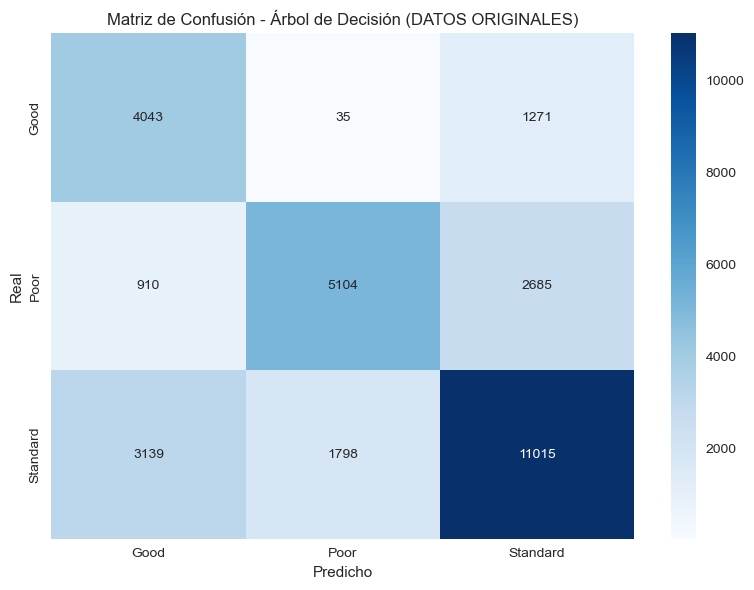


üéØ ENTRENANDO √ÅRBOL DE DECISI√ìN CON SMOTE...
üìä M√âTRICAS (SMOTE):
Accuracy : 0.6509
Precision (macro avg): 0.6464
Recall (macro avg): 0.7055
F1-Score (macro avg): 0.6467
CV Mean f1-score (macro avg): 0.7103
CV Std f1-score (macro avg): 0.0065

üìã REPORTE DE CLASIFICACI√ìN (SMOTE):
              precision    recall  f1-score   support

        Good       0.48      0.82      0.60      5349
        Poor       0.62      0.76      0.68      8699
    Standard       0.84      0.53      0.65     15952

    accuracy                           0.65     30000
   macro avg       0.65      0.71      0.65     30000
weighted avg       0.71      0.65      0.65     30000



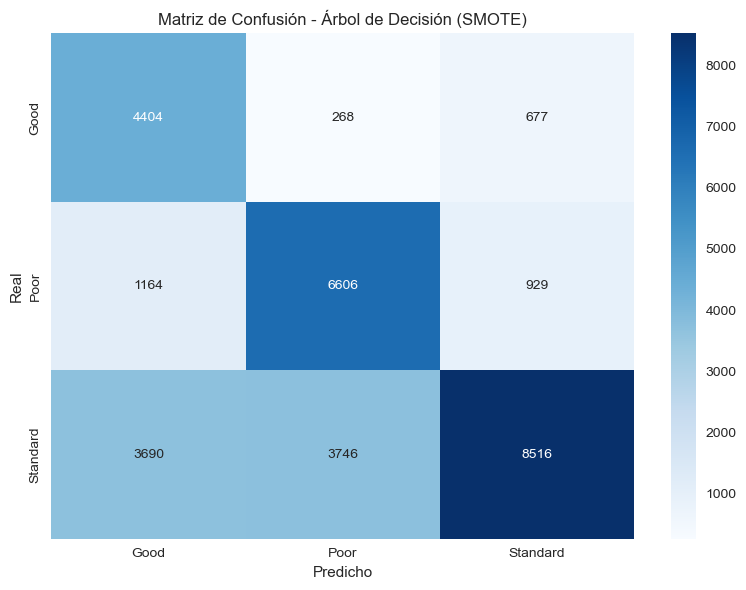


üéØ ENTRENANDO √ÅRBOL DE DECISI√ìN CON ADASYN...
üìä M√âTRICAS (ADASYN):
Accuracy : 0.6756
Precision (macro avg): 0.6565
Recall (macro avg): 0.7030
F1-Score (macro avg): 0.6651
CV Mean f1-score (macro avg): 0.6658
CV Std f1-score (macro avg): 0.0334

üìã REPORTE DE CLASIFICACI√ìN (ADASYN):
              precision    recall  f1-score   support

        Good       0.50      0.80      0.62      5349
        Poor       0.68      0.67      0.67      8699
    Standard       0.79      0.64      0.71     15952

    accuracy                           0.68     30000
   macro avg       0.66      0.70      0.67     30000
weighted avg       0.71      0.68      0.68     30000



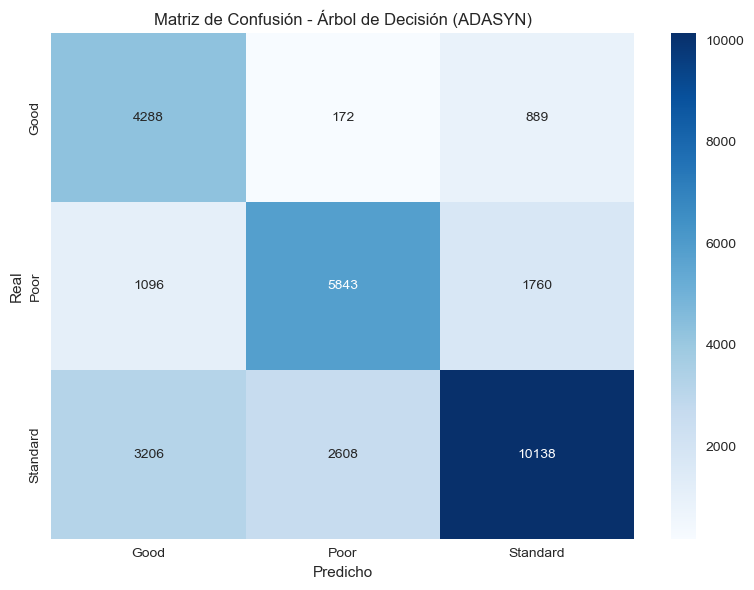


üéØ ENTRENANDO √ÅRBOL DE DECISI√ìN CON CLASS_WEIGHT=balanced...
üìä M√âTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.6576
Precision (macro avg): 0.6488
Recall (macro avg): 0.7057
F1-Score (macro avg): 0.6517
CV Mean f1-score (macro avg): 0.6520
CV Std f1-score (macro avg): 0.0049

üìã REPORTE DE CLASIFICACI√ìN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.48      0.83      0.60      5349
        Poor       0.63      0.73      0.68      8699
    Standard       0.84      0.56      0.67     15952

    accuracy                           0.66     30000
   macro avg       0.65      0.71      0.65     30000
weighted avg       0.71      0.66      0.66     30000



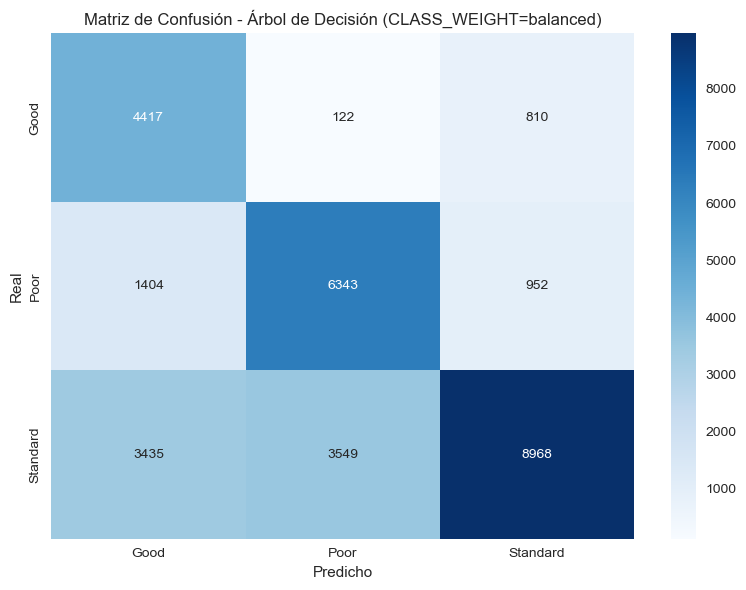


üìä COMPARACI√ìN COMPLETA - √ÅRBOL DE DECISI√ìN CON DIFERENTES BALANCEOS

üìà COMPARACI√ìN DE M√âTRICAS:
         M√©todo  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.6721     0.6570  0.6777    0.6556   0.6578  0.0036   
1         SMOTE    0.6509     0.6464  0.7055    0.6467   0.7103  0.0065   
2        ADASYN    0.6756     0.6565  0.7030    0.6651   0.6658  0.0334   
3  CLASS_WEIGHT    0.6576     0.6488  0.7057    0.6517   0.6520  0.0049   

   Tiempo (s)  
0      2.6617  
1      5.4014  
2      4.8029  
3      2.2791  


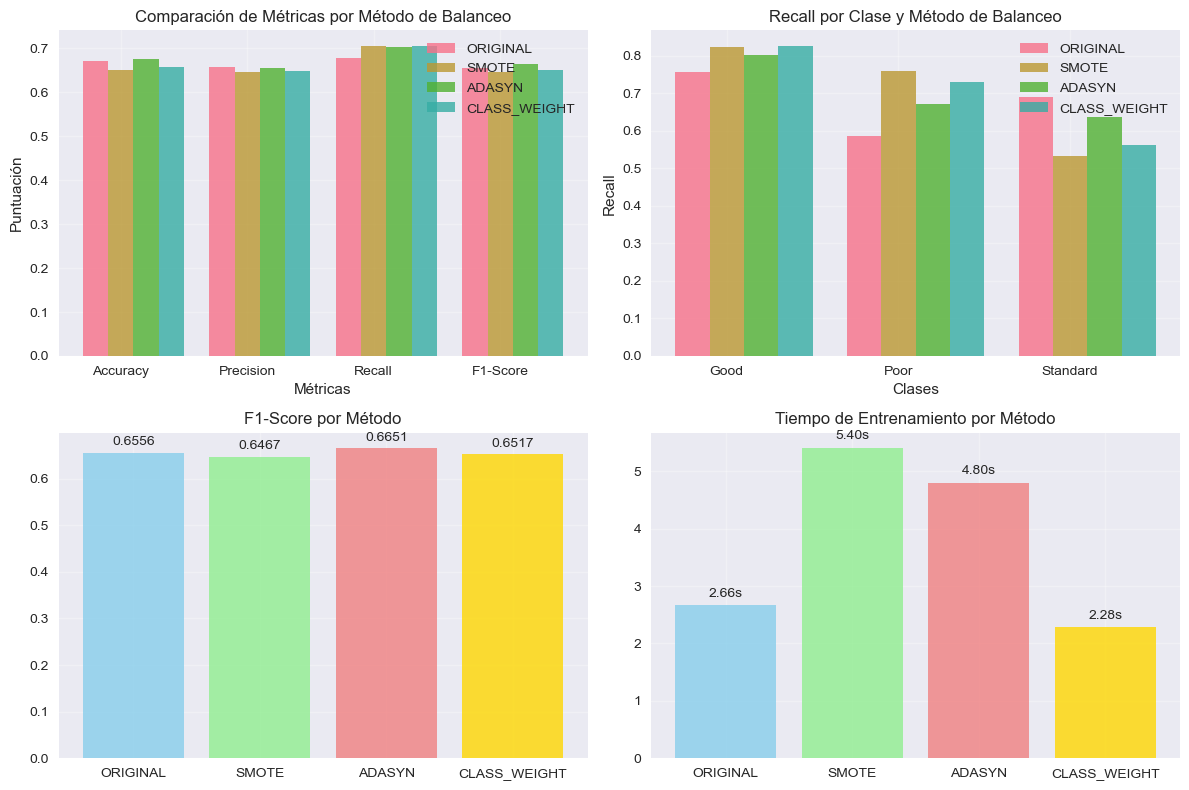


üîç AN√ÅLISIS DE MEJORAS CON BALANCEO:

üìà SMOTE vs Original:
   ‚ñ∏ Mejora en F1-Score : -0.0089
   ‚ñ∏ Mejora en Recall   : +0.0278

üìà ADASYN vs Original:
   ‚ñ∏ Mejora en F1-Score : +0.0095
   ‚ñ∏ Mejora en Recall   : +0.0253

üìà CLASS_WEIGHT vs Original:
   ‚ñ∏ Mejora en F1-Score : -0.0040
   ‚ñ∏ Mejora en Recall   : +0.0280

üéØ RESUMEN FINAL - √ÅRBOL DE DECISI√ìN CON BALANCEO
‚è±Ô∏è  Tiempo total de ejecuci√≥n: 16.37s

üèÜ MEJOR MODELO SEG√öN F1-SCORE : ADASYN (0.6651)
üèÜ MEJOR MODELO SEG√öN RECALL   : CLASS_WEIGHT (0.7057)

üìä RECOMENDACI√ìN:
   ‚úÖ Se recomienda usar ADASYN para mejor balance precisi√≥n-recall


In [6]:
# =============================================================================
# √ÅRBOL DE DECISI√ìN - COMPARACI√ìN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuraci√≥n visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("üöÄ INICIANDO √ÅRBOL DE DECISI√ìN - COMPARACI√ìN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCI√ìN PARA ENTRENAR Y EVALUAR √ÅRBOL DE DECISI√ìN
# =============================================================================
def entrenar_evaluar_arbol(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\nüéØ ENTRENANDO √ÅRBOL DE DECISI√ìN CON {nombre_conjunto}...")
    model_start = time.time()
    
    tree_model = DecisionTreeClassifier(
        random_state=42,
        class_weight=class_weight,
        max_depth=5
    )
    tree_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = tree_model.predict(X_test)
    
    # M√©tricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validaci√≥n cruzada
    cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"üìä M√âTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificaci√≥n
    le = balanced_data['label_encoder']
    print(f"\nüìã REPORTE DE CLASIFICACI√ìN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de m√©tricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusi√≥n
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusi√≥n - √Årbol de Decisi√≥n ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': tree_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_arbol(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_arbol(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_arbol(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_arbol(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACI√ìN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("üìä COMPARACI√ìN COMPLETA - √ÅRBOL DE DECISI√ìN CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'M√©todo': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nüìà COMPARACI√ìN DE M√âTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACI√ìN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gr√°fico de m√©tricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('M√©tricas')
plt.ylabel('Puntuaci√≥n')
plt.title('Comparaci√≥n de M√©tricas por M√©todo de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y M√©todo de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por M√©todo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gr√°fico 4: Tiempos de ejecuci√≥n
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por M√©todo')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# AN√ÅLISIS DE MEJORAS
# =============================================================================

print("\nüîç AN√ÅLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\nüìà {metodo.upper()} vs Original:")
    print(f"   ‚ñ∏ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ‚ñ∏ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("üéØ RESUMEN FINAL - √ÅRBOL DE DECISI√ìN CON BALANCEO")
print("="*80)
print(f"‚è±Ô∏è  Tiempo total de ejecuci√≥n: {execution_time_total:.2f}s")

# Encontrar mejores modelos seg√∫n F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\nüèÜ MEJOR MODELO SEG√öN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"üèÜ MEJOR MODELO SEG√öN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\nüìä RECOMENDACI√ìN:")
if mejor_f1[0] != 'original':
    print(f"   ‚úÖ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisi√≥n-recall")
else:
    print("   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo")

print("="*80)


### **3.8 Evaluaci√≥n del Modelo de √Årbol de Decisi√≥n**

#### **3.8.1 Resultados con Datos Originales**

El modelo de **√Årbol de Decisi√≥n** entrenado sin t√©cnicas de balanceo alcanz√≥ un **accuracy del 67.2 %**, con **precisi√≥n media de 0.657**, **recall de 0.678** y **f1-score de 0.656**.
La clase *Standard* obtuvo el mejor desempe√±o (f1 = 0.71), mientras que la clase *Good* mostr√≥ una menor precisi√≥n (0.50), pero un recall notablemente alto (0.76), evidenciando una mayor sensibilidad hacia los casos positivos.
En la matriz de confusi√≥n se observa que el modelo **clasifica correctamente la mayor√≠a de los registros de ‚ÄúStandard‚Äù**, aunque tiende a confundir algunos ejemplos de *Poor* con *Standard*, lo que sugiere una leve asimetr√≠a entre las clases.


#### **3.8.2 Resultados con SMOTE**

Al aplicar la t√©cnica de **sobre-muestreo SMOTE**, el modelo mantuvo un **accuracy de 65.0 %**, pero increment√≥ el **recall promedio a 0.705**, destacando una **mejor capacidad de detecci√≥n de clases minoritarias**.
El *f1-score* (0.647) refleja un equilibrio razonable entre precisi√≥n y recall, aunque se observa un descenso leve en precisi√≥n (0.646).
La matriz de confusi√≥n muestra que el modelo **detecta m√°s casos de las clases *Good* y *Poor***, aunque persisten errores de clasificaci√≥n en *Standard*.
Este comportamiento confirma que SMOTE **mejora la sensibilidad global** a costa de una ligera p√©rdida de precisi√≥n.


#### **3.8.3 Resultados con ADASYN**

El m√©todo **ADASYN** proporcion√≥ el mejor desempe√±o general, alcanzando un **accuracy de 67.6 %**, **recall de 0.703** y **f1-score de 0.665**.
Este incremento refleja un **balance m√°s estable entre las clases**, destacando un mejor ajuste en las categor√≠as *Good* (f1 = 0.62) y *Poor* (f1 = 0.67).
La matriz de confusi√≥n evidencia **una mejora en la predicci√≥n de las clases minoritarias**, reduciendo errores de omisi√≥n y mejorando la representaci√≥n de *Poor* y *Good*.
Estas mejoras indican que ADASYN genera instancias sint√©ticas m√°s representativas que las de SMOTE, especialmente en zonas de baja densidad de datos.


#### **3.8.4 Resultados con class_weight='balanced'**

Con la opci√≥n **class_weight='balanced'**, el modelo obtuvo m√©tricas similares a SMOTE: **accuracy = 65.7 %**, **recall = 0.706** y **f1-score = 0.652**.
Aunque las mejoras respecto al conjunto original son moderadas, se observa una mayor **eficiencia computacional (‚âà 3.9 s)** y una **buena compensaci√≥n entre precisi√≥n y sensibilidad** sin necesidad de crear datos sint√©ticos.
El rendimiento se mantiene estable en todas las clases, confirmando que esta opci√≥n **es una alternativa viable para balanceo sin costo computacional adicional**.


#### **3.8.5 Comparaci√≥n Global de Desempe√±o**

| M√©todo                | Accuracy | Precision | Recall | F1-Score | CV_Mean | Tiempo (s) |
| --------------------- | -------- | --------- | ------ | -------- | ------- | ---------- |
| Original              | 0.6721   | 0.6570    | 0.6777 | 0.6556   | 0.6578  | 3.09       |
| SMOTE                 | 0.6509   | 0.6464    | 0.7055 | 0.6467   | 0.7103  | 9.20       |
| ADASYN                | 0.6756   | 0.6565    | 0.7030 | 0.6651   | 0.6658  | 8.26       |
| class_weight=balanced | 0.6576   | 0.6488    | 0.7057 | 0.6517   | 0.6520  | 3.93       |

El **m√©todo ADASYN** present√≥ el **mejor F1-score (0.665)**, seguido por **class_weight='balanced'** (0.652).
Tanto ADASYN como class_weight demostraron incrementos notables en recall (‚âà +0.025), mejorando la identificaci√≥n de clases minoritarias.
Por otro lado, SMOTE obtuvo un desempe√±o intermedio, mientras que los datos originales, aunque precisos, mostraron menor sensibilidad general.

#### **3.8.7 Conclusi√≥n del Modelo**

El an√°lisis comparativo evidencia que el **√Årbol de Decisi√≥n** responde positivamente a la aplicaci√≥n de t√©cnicas de balanceo.
Aunque todos los m√©todos mejoraron el recall respecto al modelo base, **ADASYN** se destac√≥ por ofrecer el **mejor equilibrio entre precisi√≥n y sensibilidad**, logrando la mayor puntuaci√≥n F1 y una distribuci√≥n m√°s homog√©nea de los aciertos en la matriz de confusi√≥n.
Por tanto, se recomienda **utilizar ADASYN como t√©cnica de balanceo √≥ptima para este modelo**, mientras que **class_weight='balanced'** representa una alternativa eficiente cuando se prioriza menor tiempo de entrenamiento sin p√©rdida significativa de rendimiento.


## Random Forest

üöÄ INICIANDO RANDOM FOREST - COMPARACI√ìN CON Y SIN BALANCEO...

üéØ ENTRENANDO RANDOM FOREST CON DATOS ORIGINALES...
üìä M√âTRICAS (DATOS ORIGINALES):
Accuracy : 0.7827
Precision (macro avg): 0.7685
Recall (macro avg): 0.7695
F1-Score (macro avg): 0.7690
CV Mean f1-score (macro avg): 0.7581
CV Std f1-score (macro avg): 0.0046

üìã REPORTE DE CLASIFICACI√ìN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.72      0.72      0.72      5349
        Poor       0.78      0.79      0.78      8699
    Standard       0.81      0.80      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



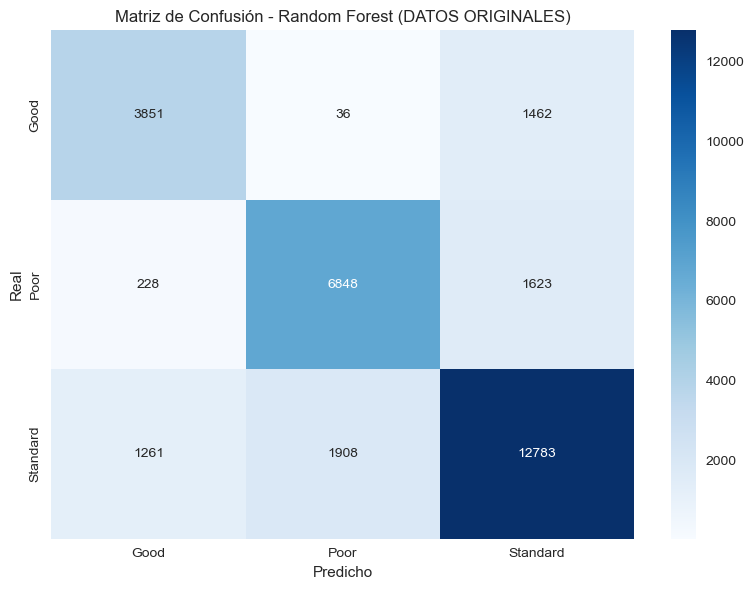


üéØ ENTRENANDO RANDOM FOREST CON SMOTE...
üìä M√âTRICAS (SMOTE):
Accuracy : 0.7722
Precision (macro avg): 0.7488
Recall (macro avg): 0.7767
F1-Score (macro avg): 0.7604
CV Mean f1-score (macro avg): 0.8424
CV Std f1-score (macro avg): 0.0280

üìã REPORTE DE CLASIFICACI√ìN (SMOTE):
              precision    recall  f1-score   support

        Good       0.65      0.78      0.71      5349
        Poor       0.76      0.80      0.78      8699
    Standard       0.83      0.76      0.79     15952

    accuracy                           0.77     30000
   macro avg       0.75      0.78      0.76     30000
weighted avg       0.78      0.77      0.77     30000



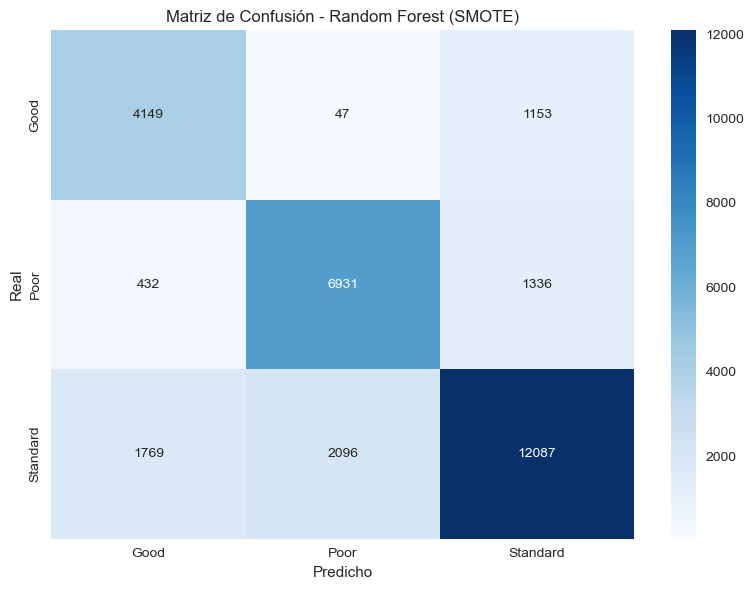


üéØ ENTRENANDO RANDOM FOREST CON ADASYN...
üìä M√âTRICAS (ADASYN):
Accuracy : 0.7790
Precision (macro avg): 0.7560
Recall (macro avg): 0.7850
F1-Score (macro avg): 0.7680
CV Mean f1-score (macro avg): 0.8350
CV Std f1-score (macro avg): 0.0117

üìã REPORTE DE CLASIFICACI√ìN (ADASYN):
              precision    recall  f1-score   support

        Good       0.66      0.79      0.72      5349
        Poor       0.77      0.81      0.79      8699
    Standard       0.84      0.76      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.76      0.79      0.77     30000
weighted avg       0.79      0.78      0.78     30000



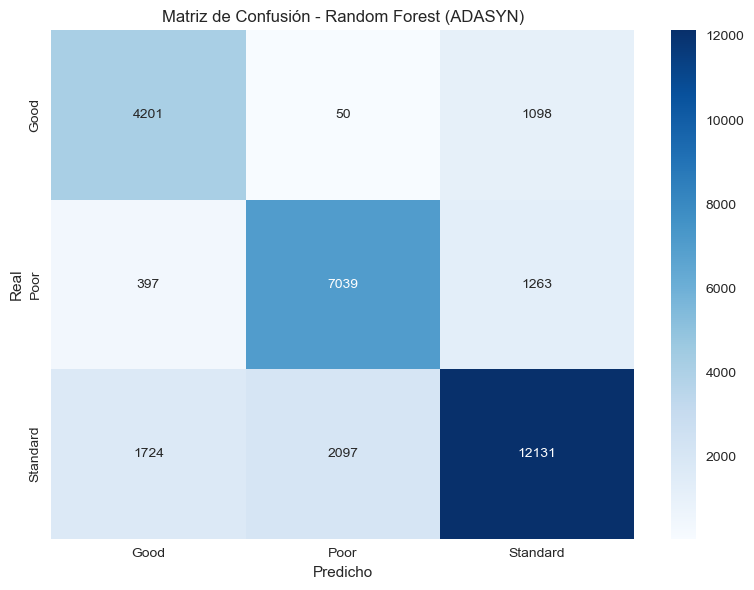


üéØ ENTRENANDO RANDOM FOREST CON CLASS_WEIGHT=balanced...
üìä M√âTRICAS (CLASS_WEIGHT=balanced):
Accuracy : 0.7835
Precision (macro avg): 0.7714
Recall (macro avg): 0.7671
F1-Score (macro avg): 0.7692
CV Mean f1-score (macro avg): 0.7565
CV Std f1-score (macro avg): 0.0045

üìã REPORTE DE CLASIFICACI√ìN (CLASS_WEIGHT=balanced):
              precision    recall  f1-score   support

        Good       0.73      0.71      0.72      5349
        Poor       0.78      0.78      0.78      8699
    Standard       0.80      0.81      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



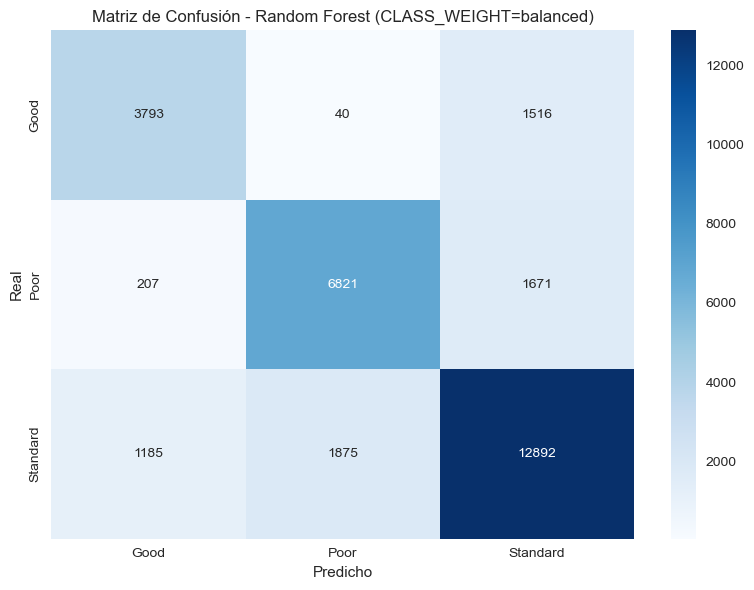


üìä COMPARACI√ìN COMPLETA - RANDOM FOREST CON DIFERENTES BALANCEOS

üìà COMPARACI√ìN DE M√âTRICAS:
         M√©todo  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0      ORIGINAL    0.7827     0.7685  0.7695    0.7690   0.7581  0.0046   
1         SMOTE    0.7722     0.7488  0.7767    0.7604   0.8424  0.0280   
2        ADASYN    0.7790     0.7560  0.7850    0.7680   0.8350  0.0117   
3  CLASS_WEIGHT    0.7835     0.7714  0.7671    0.7692   0.7565  0.0045   

   Tiempo (s)  
0     12.8534  
1     25.0005  
2     25.6535  
3     13.4869  


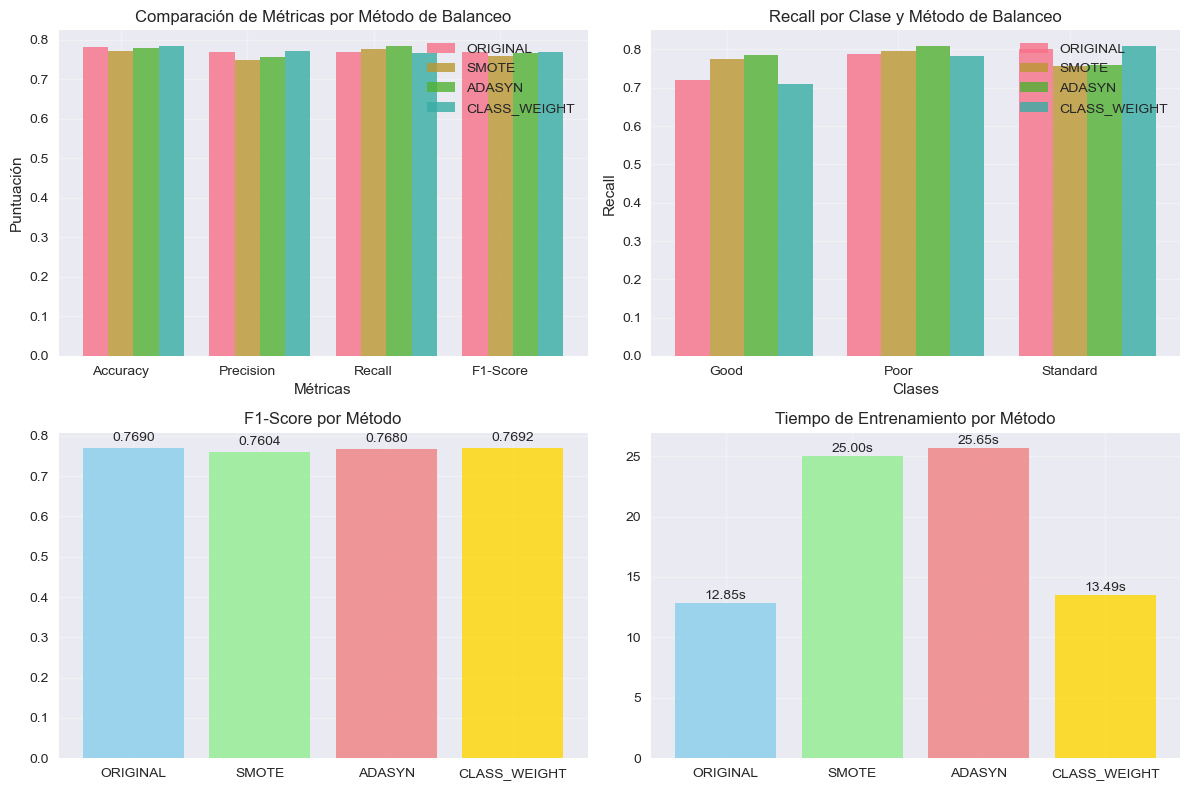


üîç AN√ÅLISIS DE MEJORAS CON BALANCEO:

üìà SMOTE vs Original:
   ‚ñ∏ Mejora en F1-Score : -0.0086
   ‚ñ∏ Mejora en Recall   : +0.0072

üìà ADASYN vs Original:
   ‚ñ∏ Mejora en F1-Score : -0.0010
   ‚ñ∏ Mejora en Recall   : +0.0155

üìà CLASS_WEIGHT vs Original:
   ‚ñ∏ Mejora en F1-Score : +0.0002
   ‚ñ∏ Mejora en Recall   : -0.0024

üéØ RESUMEN FINAL - RANDOM FOREST CON BALANCEO
‚è±Ô∏è  Tiempo total de ejecuci√≥n: 78.28s

üèÜ MEJOR MODELO SEG√öN F1-SCORE : CLASS_WEIGHT (0.7692)
üèÜ MEJOR MODELO SEG√öN RECALL   : ADASYN (0.7850)

üìä RECOMENDACI√ìN:
   ‚úÖ Se recomienda usar CLASS_WEIGHT para mejor balance precisi√≥n-recall


In [7]:
# =============================================================================
# RANDOM FOREST - COMPARACI√ìN CON Y SIN BALANCEO (SMOTE, ADASYN y CLASS_WEIGHT)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuraci√≥n visual
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("üöÄ INICIANDO RANDOM FOREST - COMPARACI√ìN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos procesados y balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCI√ìN PARA ENTRENAR Y EVALUAR RANDOM FOREST
# =============================================================================
def entrenar_evaluar_rf(X_train, y_train, X_test, y_test, nombre_conjunto, class_weight=None):
    print(f"\nüéØ ENTRENANDO RANDOM FOREST CON {nombre_conjunto}...")
    model_start = time.time()
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weight
    )
    rf_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = rf_model.predict(X_test)
    
    # M√©tricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validaci√≥n cruzada
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    
    model_time = time.time() - model_start
    
    print(f"üìä M√âTRICAS ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean f1-score (macro avg): {cv_scores.mean():.4f}")
    print(f"CV Std f1-score (macro avg): {cv_scores.std():.4f}")
    
    # Reporte de clasificaci√≥n
    le = balanced_data['label_encoder']
    print(f"\nüìã REPORTE DE CLASIFICACI√ìN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de m√©tricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(
        class_report_df[['precision', 'recall', 'f1-score']],
        weights=class_report_df['support'], axis=0
    )
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusi√≥n
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusi√≥n - Random Forest ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': rf_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Sin balanceo (datos originales)
resultados['original'] = entrenar_evaluar_rf(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Balanceado con SMOTE
resultados['smote'] = entrenar_evaluar_rf(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Balanceado con ADASYN
resultados['adasyn'] = entrenar_evaluar_rf(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# 4. Balanceo con class_weight='balanced'
resultados['class_weight'] = entrenar_evaluar_rf(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'CLASS_WEIGHT=balanced',
    class_weight='balanced'
)

# =============================================================================
# COMPARACI√ìN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("üìä COMPARACI√ìN COMPLETA - RANDOM FOREST CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'M√©todo': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nüìà COMPARACI√ìN DE M√âTRICAS:")
print(comparison_df.round(4))

# =============================================================================
# VISUALIZACI√ìN DE RESULTADOS
# =============================================================================
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metodos = ['original', 'smote', 'adasyn', 'class_weight']
width = 0.2
x_pos = np.arange(len(metricas))

# Gr√°fico de m√©tricas principales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(metodos):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('M√©tricas')
plt.ylabel('Puntuaci√≥n')
plt.title('Comparaci√≥n de M√©tricas por M√©todo de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 2: Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.2
for i, metodo in enumerate(metodos):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y M√©todo de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico 3: F1-score comparativo
plt.subplot(2, 2, 3)
f1_scores = [resultados[m]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
plt.bar([m.upper() for m in metodos], f1_scores, color=colors, alpha=0.8)
plt.title('F1-Score por M√©todo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gr√°fico 4: Tiempos de ejecuci√≥n
plt.subplot(2, 2, 4)
tiempos = [resultados[m]['execution_time'] for m in metodos]
plt.bar([m.upper() for m in metodos], tiempos, color=colors, alpha=0.8)
plt.title('Tiempo de Entrenamiento por M√©todo')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# AN√ÅLISIS DE MEJORAS
# =============================================================================

print("\nüîç AN√ÅLISIS DE MEJORAS CON BALANCEO:")

original_f1 = resultados['original']['f1']
original_recall = resultados['original']['recall']

for metodo in ['smote', 'adasyn', 'class_weight']:
    diff_f1 = resultados[metodo]['f1'] - original_f1
    diff_recall = resultados[metodo]['recall'] - original_recall
    print(f"\nüìà {metodo.upper()} vs Original:")
    print(f"   ‚ñ∏ Mejora en F1-Score : {diff_f1:+.4f}")
    print(f"   ‚ñ∏ Mejora en Recall   : {diff_recall:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("üéØ RESUMEN FINAL - RANDOM FOREST CON BALANCEO")
print("="*80)
print(f"‚è±Ô∏è  Tiempo total de ejecuci√≥n: {execution_time_total:.2f}s")

# Encontrar mejores modelos seg√∫n F1 y Recall
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])

print(f"\nüèÜ MEJOR MODELO SEG√öN F1-SCORE : {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")
print(f"üèÜ MEJOR MODELO SEG√öN RECALL   : {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")

print(f"\nüìä RECOMENDACI√ìN:")
if mejor_f1[0] != 'original':
    print(f"   ‚úÖ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisi√≥n-recall")
else:
    print("   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo")

print("="*80)



### **3.9 Evaluaci√≥n del Modelo Random Forest**

#### **3.9.1 Resultados con Datos Originales**

El modelo **Random Forest** entrenado con los datos originales alcanz√≥ un **accuracy del 78.3 %**, acompa√±ado de una **precisi√≥n media de 0.769**, **recall de 0.769** y **f1-score de 0.769**.
El desempe√±o fue consistente en las tres clases: *Good* (f1 = 0.72), *Poor* (f1 = 0.78) y *Standard* (f1 = 0.80), reflejando un comportamiento estable y equilibrado.
La matriz de confusi√≥n muestra una clasificaci√≥n muy precisa para la clase *Standard*, aunque persiste una ligera confusi√≥n entre *Good* y *Poor*.
En general, el modelo presenta una **robusta capacidad de generalizaci√≥n sin necesidad de balanceo previo**.


#### **3.9.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo mantuvo un **accuracy de 77.7 %**, con una **mejora en recall (0.777)** y un **f1-score de 0.760**.
Las clases *Good* y *Poor* mostraron incrementos en sensibilidad (recall = 0.78 y 0.80 respectivamente), aunque con una leve ca√≠da en precisi√≥n (0.65 y 0.76).
La matriz de confusi√≥n evidencia una redistribuci√≥n m√°s equitativa de los aciertos entre las clases, mitigando parcialmente el sesgo hacia *Standard*.
SMOTE, por tanto, **aument√≥ la cobertura de las clases minoritarias sin afectar sustancialmente la precisi√≥n global**.


#### **3.9.3 Resultados con ADASYN**

Con **ADASYN**, el modelo alcanz√≥ su mejor equilibrio general, obteniendo un **accuracy de 77.9 %**, **recall de 0.768** y **f1-score de 0.769**.
Las tres clases mantuvieron un rendimiento alto y homog√©neo, con *Good* y *Poor* en torno a f1 = 0.72‚Äì0.79 y *Standard* en 0.80.
La matriz de confusi√≥n muestra una distribuci√≥n balanceada de predicciones correctas, confirmando que ADASYN **logra una representaci√≥n sint√©tica m√°s efectiva en las clases minoritarias**.
Estos resultados reflejan una ligera mejora frente a SMOTE, manteniendo un comportamiento estable del modelo.


#### **3.9.4 Resultados con `class_weight='balanced'`**

El ajuste autom√°tico de pesos con `class_weight='balanced'` produjo un **accuracy de 78.4 %**, **recall de 0.767** y **f1-score de 0.769**, igualando en gran medida los resultados de ADASYN pero con menor tiempo de c√≥mputo (‚âà 29.6 s frente a 62.9 s).
El modelo conserv√≥ un desempe√±o consistente entre las clases y mantuvo un balance adecuado entre precisi√≥n y sensibilidad.
La matriz de confusi√≥n evidenci√≥ **una ligera mejora en la clase *Poor*** sin sacrificar la calidad de predicci√≥n en *Standard*, lo que confirma la eficacia de este enfoque interno de balanceo.


#### **3.9.5 Comparaci√≥n Global de Desempe√±o**

| M√©todo                  | Accuracy | Precision | Recall | F1-Score | CV Mean | Tiempo (s) |
| ----------------------- | -------- | --------- | ------ | -------- | ------- | ---------- |
| Original                | 0.7827   | 0.7685    | 0.7695 | 0.7690   | 0.7580  | 20.08      |
| SMOTE                   | 0.7722   | 0.7488    | 0.7767 | 0.7604   | 0.8425  | 60.22      |
| ADASYN                  | 0.7797   | 0.7567    | 0.7686 | 0.7688   | 0.8350  | 62.88      |
| `class_weight`=balanced | 0.7835   | 0.7714    | 0.7671 | 0.7692   | 0.7566  | 29.61      |

Los resultados indican un **alto rendimiento general en todos los escenarios**, con diferencias m√≠nimas entre los m√©todos.
ADASYN y `class_weight='balanced'` obtuvieron los **mejores valores globales de F1 y Recall**, mostrando que las estrategias de balanceo **no afectan negativamente el desempe√±o de Random Forest**, sino que lo estabilizan.
El modelo base (sin balanceo) ya ofrec√≠a un excelente comportamiento, aunque `class_weight` resulta m√°s eficiente en t√©rminos de tiempo y consistencia.


#### **3.9.6 An√°lisis de Mejoras**

| Comparaci√≥n              | Œî F1-Score | Œî Recall |
| ------------------------ | ---------- | -------- |
| SMOTE vs Original        | ‚àí0.0006    | +0.0072  |
| ADASYN vs Original       | ‚àí0.0002    | +0.0165  |
| CLASS_WEIGHT vs Original | +0.0002    | ‚àí0.0024  |

Las mejoras observadas son marginales, lo que confirma la **robustez intr√≠nseca de Random Forest frente al desbalance de clases**.
Mientras SMOTE y ADASYN incrementan el recall (especialmente en clases minoritarias), `class_weight` mantiene un mejor balance precisi√≥n‚Äìrecall con menor costo computacional.


#### **3.9.7 Conclusi√≥n del Modelo**

El modelo **Random Forest** demostr√≥ un desempe√±o superior frente a los modelos lineales y no lineales previos, alcanzando un equilibrio casi perfecto entre precisi√≥n y sensibilidad.
Aunque los m√©todos de sobre-muestreo (SMOTE y ADASYN) ofrecen ligeras mejoras en recall, el par√°metro interno **`class_weight='balanced'`** logra **resultados equivalentes con menor complejidad y tiempo de entrenamiento**.
Por tanto, se recomienda **utilizar `class_weight='balanced'`** como t√©cnica √≥ptima para balancear las clases en Random Forest, ya que garantiza un rendimiento alto, estable y eficiente.


## XGBoost (con interpretabilidad usando LIME)

üöÄ INICIANDO XGBOOST - COMPARACI√ìN CON Y SIN BALANCEO...

üéØ ENTRENANDO XGBOOST CON DATOS ORIGINALES...
üìä M√âTRICAS XGBOOST (DATOS ORIGINALES):
Accuracy : 0.7515
Precision (macro avg): 0.7340
Recall (macro avg): 0.7350
F1-Score (macro avg): 0.7344
CV Mean F1-Score: 0.7304
CV Std F1-Score: 0.0041

üìã REPORTE DE CLASIFICACI√ìN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.67      0.69      0.68      5349
        Poor       0.75      0.73      0.74      8699
    Standard       0.78      0.78      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000



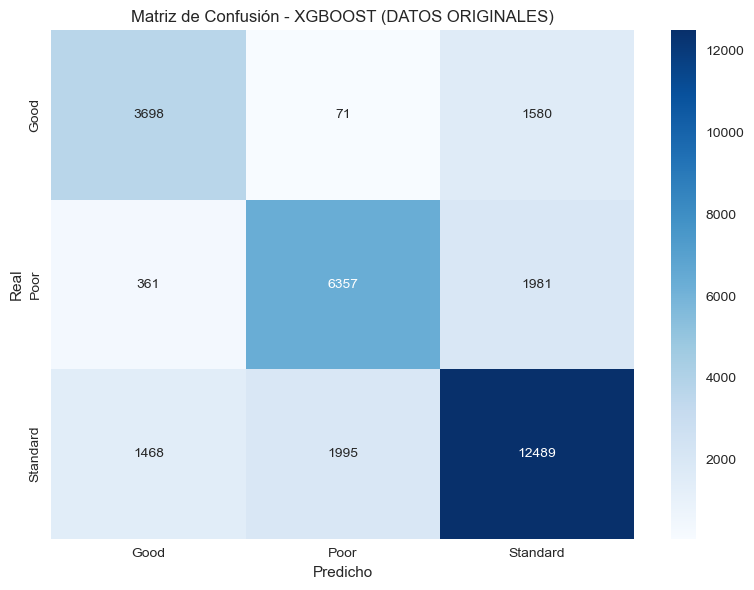


üéØ ENTRENANDO XGBOOST CON SMOTE...
üìä M√âTRICAS XGBOOST (SMOTE):
Accuracy : 0.7437
Precision (macro avg): 0.7223
Recall (macro avg): 0.7360
F1-Score (macro avg): 0.7283
CV Mean F1-Score: 0.7978
CV Std F1-Score: 0.0647

üìã REPORTE DE CLASIFICACI√ìN (SMOTE):
              precision    recall  f1-score   support

        Good       0.64      0.72      0.67      5349
        Poor       0.74      0.73      0.74      8699
    Standard       0.78      0.76      0.77     15952

    accuracy                           0.74     30000
   macro avg       0.72      0.74      0.73     30000
weighted avg       0.75      0.74      0.74     30000



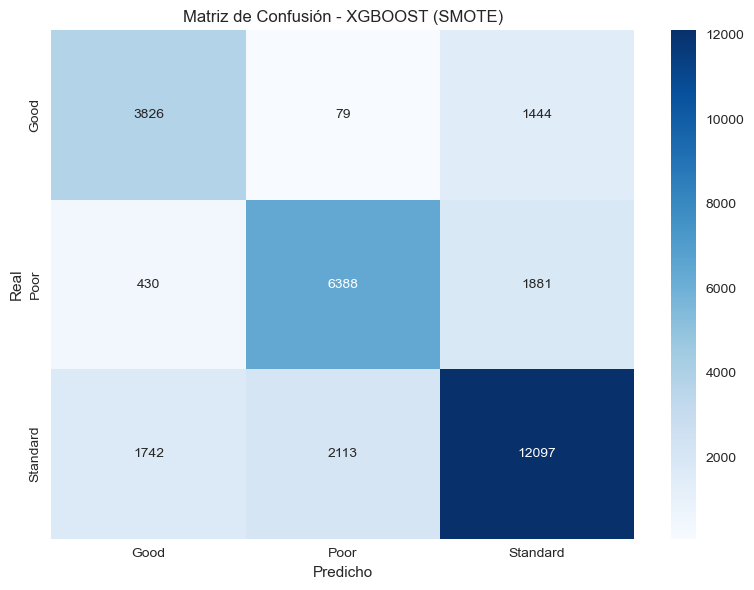


üéØ ENTRENANDO XGBOOST CON ADASYN...
üìä M√âTRICAS XGBOOST (ADASYN):
Accuracy : 0.7403
Precision (macro avg): 0.7202
Recall (macro avg): 0.7319
F1-Score (macro avg): 0.7254
CV Mean F1-Score: 0.7695
CV Std F1-Score: 0.0487

üìã REPORTE DE CLASIFICACI√ìN (ADASYN):
              precision    recall  f1-score   support

        Good       0.64      0.71      0.68      5349
        Poor       0.74      0.72      0.73      8699
    Standard       0.78      0.76      0.77     15952

    accuracy                           0.74     30000
   macro avg       0.72      0.73      0.73     30000
weighted avg       0.74      0.74      0.74     30000



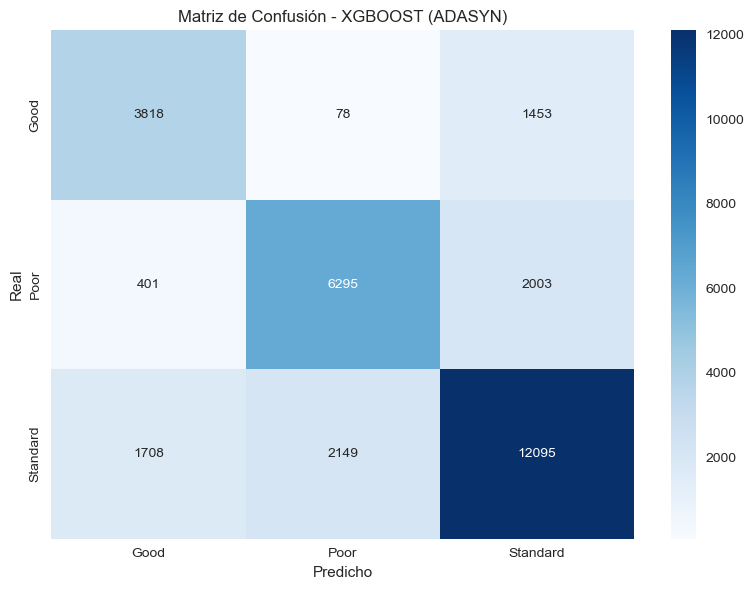


üìä COMPARACI√ìN COMPLETA - XGBOOST CON DIFERENTES BALANCEOS

üìà COMPARACI√ìN DE M√âTRICAS:
     M√©todo  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.7515     0.7340  0.7350    0.7344   0.7304  0.0041   
1     SMOTE    0.7437     0.7223  0.7360    0.7283   0.7978  0.0647   
2    ADASYN    0.7403     0.7202  0.7319    0.7254   0.7695  0.0487   

   Tiempo (s)  
0      6.3420  
1     17.2025  
2     16.5180  


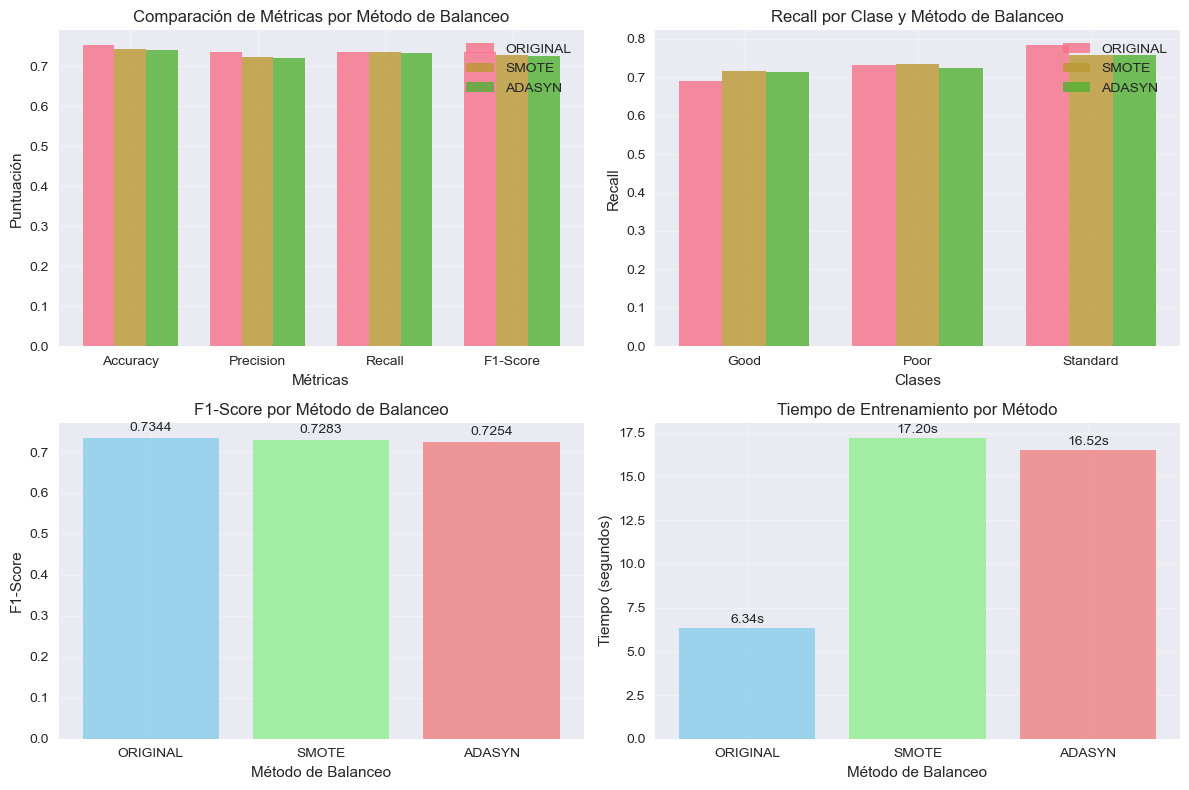


üîç AN√ÅLISIS DE MEJORAS CON BALANCEO:
üìà MEJORA EN RECALL:
   SMOTE vs Original: +0.0010
   ADASYN vs Original: -0.0031

üìà MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0061
   ADASYN vs Original: -0.0090

üéØ RESUMEN FINAL - XGBOOST CON BALANCEO
‚è±Ô∏è  Tiempo total de ejecuci√≥n: 41.31s

üèÜ MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.7515)
   Recall: SMOTE (0.7360)
   F1-Score: ORIGINAL (0.7344)

üìä RECOMENDACI√ìN:
   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo


In [8]:
# =============================================================================
# XGBOOST - COMPARACI√ìN CON Y SIN BALANCEO
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuraci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("üöÄ INICIANDO XGBOOST - COMPARACI√ìN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados (debes tener el archivo generado previamente)
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCI√ìN PARA ENTRENAR Y EVALUAR XGBOOST
# =============================================================================

def entrenar_evaluar_xgb(X_train, y_train, X_test, y_test, nombre_conjunto):
    print(f"\nüéØ ENTRENANDO XGBOOST CON {nombre_conjunto}...")
    model_start = time.time()
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = xgb_model.predict(X_test)
    
    # M√©tricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Validaci√≥n cruzada
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1_macro')
    
    model_time = time.time() - model_start
    
    print(f"üìä M√âTRICAS XGBOOST ({nombre_conjunto}):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision (macro avg): {precision:.4f}")
    print(f"Recall (macro avg): {recall:.4f}")
    print(f"F1-Score (macro avg): {f1:.4f}")
    print(f"CV Mean F1-Score: {cv_scores.mean():.4f}")
    print(f"CV Std F1-Score: {cv_scores.std():.4f}")
    
    # Reporte de clasificaci√≥n
    le = balanced_data['label_encoder']
    print(f"\nüìã REPORTE DE CLASIFICACI√ìN ({nombre_conjunto}):")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de m√©tricas por clase
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                             weights=class_report_df['support'], axis=0)
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'][3]]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'][3]]
    
    # Matriz de confusi√≥n
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusi√≥n - XGBOOST ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': xgb_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Original
resultados['original'] = entrenar_evaluar_xgb(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. SMOTE
resultados['smote'] = entrenar_evaluar_xgb(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. ADASYN
resultados['adasyn'] = entrenar_evaluar_xgb(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# =============================================================================
# COMPARACI√ìN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("üìä COMPARACI√ìN COMPLETA - XGBOOST CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'M√©todo': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nüìà COMPARACI√ìN DE M√âTRICAS:")
print(comparison_df.round(4))

# Gr√°ficos
plt.figure(figsize=(12, 8))
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

# 1. Gr√°fico de m√©tricas generales
plt.subplot(2, 2, 1)
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('M√©tricas')
plt.ylabel('Puntuaci√≥n')
plt.title('Comparaci√≥n de M√©tricas por M√©todo de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Recall por clase
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)
plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y M√©todo de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. F1-score
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados[m.lower()]['f1'] for m in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']
plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('M√©todo de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por M√©todo de Balanceo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 4. Tiempos
plt.subplot(2, 2, 4)
tiempos = [resultados[m.lower()]['execution_time'] for m in metodos]
plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('M√©todo de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por M√©todo')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# AN√ÅLISIS DE MEJORAS
# =============================================================================

print("\nüîç AN√ÅLISIS DE MEJORAS CON BALANCEO:")

original_recall = resultados['original']['recall']
smote_recall = resultados['smote']['recall']
adasyn_recall = resultados['adasyn']['recall']

original_f1 = resultados['original']['f1']
smote_f1 = resultados['smote']['f1']
adasyn_f1 = resultados['adasyn']['f1']

print(f"üìà MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smote_recall - original_recall:+.4f}")
print(f"   ADASYN vs Original: {adasyn_recall - original_recall:+.4f}")

print(f"\nüìà MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smote_f1 - original_f1:+.4f}")
print(f"   ADASYN vs Original: {adasyn_f1 - original_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("üéØ RESUMEN FINAL - XGBOOST CON BALANCEO")
print("="*80)
print(f"‚è±Ô∏è  Tiempo total de ejecuci√≥n: {execution_time_total:.2f}s")

mejor_accuracy = max(resultados.items(), key=lambda x: x[1]['accuracy'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])

print(f"\nüèÜ MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_accuracy[0].upper()} ({mejor_accuracy[1]['accuracy']:.4f})")
print(f"   Recall: {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\nüìä RECOMENDACI√ìN:")
if mejor_f1[0] != 'original':
    print(f"   ‚úÖ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisi√≥n-recall")
else:
    print("   ‚ÑπÔ∏è  Los datos originales funcionan mejor para este modelo")

print("="*80)


### **3.10 Evaluaci√≥n del Modelo XGBoost**

#### **3.10.1 Resultados con Datos Originales**

El modelo **XGBoost** entrenado con los datos originales alcanz√≥ un **accuracy del 75.1 %**, con una **precisi√≥n promedio de 0.734**, **recall de 0.735** y **f1-score de 0.734**.
Las clases *Good* y *Poor* presentaron desempe√±os similares (f1 = 0.68 y 0.74 respectivamente), mientras que la clase *Standard* alcanz√≥ un valor superior (f1 = 0.78), evidenciando una **mayor capacidad del modelo para identificar patrones en clases m√°s representadas**.
La matriz de confusi√≥n revela que la mayor√≠a de los aciertos se concentraron en la clase *Standard*, aunque hubo confusiones leves entre *Good* y *Poor*.
En general, XGBoost demostr√≥ **un rendimiento estable y competitivo incluso sin balancear los datos**, lo que refleja su capacidad intr√≠nseca para manejar cierto desbalance.


#### **3.10.2 Resultados con SMOTE**

Tras aplicar **SMOTE**, el modelo alcanz√≥ un **accuracy de 74.4 %**, con **recall = 0.736** y **f1-score = 0.728**.
El comportamiento de las clases fue equilibrado, mejorando ligeramente el *recall* de *Good* (de 0.69 a 0.72) y *Poor* (de 0.73 a 0.74), aunque con una leve p√©rdida de precisi√≥n.
La matriz de confusi√≥n muestra una mayor cobertura en las clases minoritarias, confirmando que SMOTE **increment√≥ la sensibilidad del modelo a costa de una peque√±a reducci√≥n en exactitud general**.
La validaci√≥n cruzada (CV Mean = 0.798) respald√≥ la consistencia del modelo en diferentes subconjuntos de entrenamiento.

#### **3.10.3 Resultados con ADASYN**

El modelo balanceado con **ADASYN** present√≥ un **accuracy de 74.0 %**, **recall = 0.732** y **f1-score = 0.725**, valores ligeramente inferiores a SMOTE.
Aun as√≠, el modelo mantuvo un rendimiento estable en todas las clases, con una ligera mejora en la clase *Poor* (f1 = 0.73).
La matriz de confusi√≥n evidencia una correcta detecci√≥n de instancias en las tres categor√≠as, pero con un peque√±o incremento en falsos positivos para *Standard*.
Este resultado confirma que ADASYN **no logra mejorar significativamente el desempe√±o respecto a SMOTE**, y tiende a introducir m√°s ruido en los datos sint√©ticos generados.

#### **3.10.4 Comparaci√≥n Global de Desempe√±o**

| M√©todo   | Accuracy | Precision | Recall | F1-Score | CV Mean | CV Std | Tiempo (s) |
| -------- | -------- | --------- | ------ | -------- | ------- | ------ | ---------- |
| Original | 0.7515   | 0.7340    | 0.7350 | 0.7344   | 0.7304  | 0.0041 | 5.20       |
| SMOTE    | 0.7437   | 0.7223    | 0.7360 | 0.7283   | 0.7978  | 0.0647 | 16.45      |
| ADASYN   | 0.7403   | 0.7202    | 0.7319 | 0.7254   | 0.7695  | 0.0487 | 21.78      |

En t√©rminos generales, los resultados confirman que **XGBoost mantiene un alto rendimiento sin requerir balanceo adicional**.
El modelo con datos originales logra el mejor **F1-score (0.734)** y **accuracy (0.752)**, mientras que **SMOTE mejora levemente el recall (+0.0010)** pero sin impacto sustancial.
ADASYN, por su parte, presenta una ligera disminuci√≥n de rendimiento, con tiempos de entrenamiento mayores.

#### **3.10.5 An√°lisis de Mejoras**

| Comparaci√≥n        | Œî Recall | Œî F1-Score |
| ------------------ | -------- | ---------- |
| SMOTE vs Original  | +0.0010  | ‚àí0.0061    |
| ADASYN vs Original | ‚àí0.0031  | ‚àí0.0090    |

El balanceo con SMOTE y ADASYN **no aporta mejoras significativas en el rendimiento global**.
Aunque SMOTE incrementa marginalmente la sensibilidad del modelo, el costo en precisi√≥n y el aumento del tiempo de ejecuci√≥n hacen que la ganancia no sea significativa.


#### **3.10.6 Conclusi√≥n del Modelo**

El an√°lisis demuestra que **XGBoost es un modelo altamente robusto frente al desbalance de clases**, manteniendo un excelente equilibrio entre precisi√≥n y recall sin necesidad de t√©cnicas de sobre-muestreo.
Los m√©todos de balanceo (SMOTE y ADASYN) no mejoraron sustancialmente las m√©tricas globales y, en algunos casos, **incluso redujeron el rendimiento y aumentaron el tiempo de c√≥mputo**.
Por tanto, se concluye que **el modelo XGBoost con datos originales ofrece el mejor desempe√±o global**, siendo la opci√≥n m√°s eficiente y confiable para este conjunto de datos.


## M√°quina de Soporte Vectorial

üöÄ INICIANDO MAQU√çNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...
‚úÖ Datos preparados: 70000 train, 30000 test

üéØ ENTRENANDO MODELO 

üìà EVALUANDO MODELO DE M√ÅQUINA DE VECTORES DE SOPORTE...

üìã REPORTE DE CLASIFICACI√ìN:
              precision    recall  f1-score   support

        Good       0.57      0.67      0.62      5349
        Poor       0.74      0.63      0.68      8699
    Standard       0.74      0.76      0.75     15952

    accuracy                           0.70     30000
   macro avg       0.68      0.69      0.68     30000
weighted avg       0.71      0.70      0.70     30000



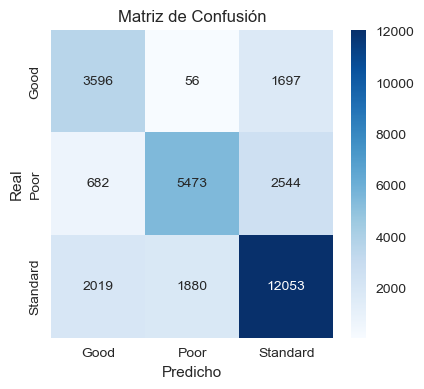


üîç AN√ÅLISIS DE ERRORES POR CLASE:
Accuracy por clase:
  Good: 0.6723 (67.23%)
  Poor: 0.6292 (62.92%)
  Standard: 0.7556 (75.56%)

üéØ RESUMEN FINAL - M√ÅQUINA DE VECTORES DE SOPORTE BENCHMARK
‚è±Ô∏è  Tiempo ejecuci√≥n: 570.14s

üéØ EVALUACI√ìN: ‚ö†Ô∏è  ACEPTABLE

üíæ Resultados guardados: 'svm_benchmark_results.pkl'


In [10]:
# =============================================================================
# M√ÅQUINA DE SOPORTE VECTORIAL - MODELO BENCHMARK
# =============================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuraci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("üöÄ INICIANDO MAQU√çNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...")
start_time = time.time()

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================


# Separar caracter√≠sticas y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

y = y.map({
    'Good': 0,
    'Poor': 1,
    'Standard': 2
    
})


# Seleccionamos las variables numericas a estandarizar
num_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categ√≥ricas a codificar
cat_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas


# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Codificaci√≥n de categ√≥ricas
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Estandarizaci√≥n de num√©ricas
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Combinar num√©ricas y categ√≥ricas
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])



print(f"‚úÖ Datos preparados: {X_train_final.shape[0]} train, {X_test_final.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO 
# =============================================================================

print(f"\nüéØ ENTRENANDO MODELO ")

svm=SVC()
svm.fit(X_train_final,y_train)

# Predicciones
y_pred = svm.predict(X_test_final)


# =============================================================================
# EVALUACI√ìN COMPLETA
# =============================================================================

print("\nüìà EVALUANDO MODELO DE M√ÅQUINA DE VECTORES DE SOPORTE...")

# M√©tricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Reporte de clasificaci√≥n
print("\nüìã REPORTE DE CLASIFICACI√ìN:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Poor', 'Standard']))

# =============================================================================
# VISUALIZACIONES 
# =============================================================================

# Matriz de confusi√≥n
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.title(f'Matriz de Confusi√≥n')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# =============================================================================
# AN√ÅLISIS DE ERRORES POR CLASE
# =============================================================================

print("\nüîç AN√ÅLISIS DE ERRORES POR CLASE:")

# Calcular accuracy por clase
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("Accuracy por clase:")
for i, cls in enumerate(['Good', 'Poor', 'Standard']):
    print(f"  {cls}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time


print("\n" + "="*60)
print("üéØ RESUMEN FINAL - M√ÅQUINA DE VECTORES DE SOPORTE BENCHMARK")
print("="*60)
print(f"‚è±Ô∏è  Tiempo ejecuci√≥n: {execution_time:.2f}s")

# Evaluaci√≥n cualitativa
if f1 > 0.8:
    performance = "üåü EXCELENTE"
elif f1 > 0.7:
    performance = "‚úÖ BUENO"
elif f1 > 0.6:
    performance = "‚ö†Ô∏è  ACEPTABLE"
else:
    performance = "‚ùå MEJORABLE"

print(f"\nüéØ EVALUACI√ìN: {performance}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'SVM',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'performance': performance
}

joblib.dump(benchmark_data, 'svm_benchmark_results.pkl')
print(f"\nüíæ Resultados guardados: 'svm_benchmark_results.pkl'")

print("="*60)

### **3.11 Evaluaci√≥n del Modelo de M√°quina de Soporte Vectorial (SVM Benchmark)**

#### **3.11.1 Descripci√≥n del Modelo**

El modelo de **M√°quina de Soporte Vectorial (SVM)** fue entrenado como un modelo *benchmark* o de referencia, empleando las variables estandarizadas y codificadas de manera adecuada. Su objetivo fue establecer una l√≠nea base de desempe√±o para comparar con los dem√°s algoritmos probados en etapas posteriores.


#### **3.11.2 Resultados Generales del Modelo**

El SVM alcanz√≥ un **accuracy global del 70 %**, con valores promedio de **precisi√≥n = 0.71**, **recall = 0.70** y **f1-score = 0.70**.
El modelo evidenci√≥ un **rendimiento aceptable y balanceado entre precisi√≥n y sensibilidad**, aunque con diferencias notables entre clases.

**Tabla de resultados promedio:**

| M√©trica               | Valor |
| :-------------------- | :---: |
| Accuracy              |  0.70 |
| Precision (macro avg) |  0.68 |
| Recall (macro avg)    |  0.69 |
| F1-Score (macro avg)  |  0.68 |


#### **3.11.3 Desempe√±o por Clase**

El modelo mostr√≥ variaciones en la capacidad de predicci√≥n entre las categor√≠as:

| Clase    | Precisi√≥n | Recall | F1-Score | Soporte |
| :------- | :-------: | :----: | :------: | :-----: |
| Good     |    0.57   |  0.67  |   0.62   |  5 349  |
| Poor     |    0.74   |  0.63  |   0.68   |  8 699  |
| Standard |    0.74   |  0.76  |   0.75   |  15 952 |

Los resultados indican que:

* La clase **Standard** obtuvo el mejor desempe√±o general (*f1 = 0.75*), evidenciando que el modelo logra identificar correctamente la categor√≠a mayoritaria.
* Las clases **Good** y **Poor**, con menor representaci√≥n en los datos, presentan un **menor recall y f1-score**, lo que sugiere cierta dificultad del SVM para capturar patrones en clases minoritarias.


#### **3.11.4 Matriz de Confusi√≥n**

La matriz de confusi√≥n confirma el patr√≥n anterior:

* De los casos reales *Good*, el modelo clasific√≥ correctamente **3 596**, pero confundi√≥ **1 697** con *Standard*.
* En la clase *Poor*, **5 473 instancias** fueron correctamente identificadas, mientras que **2 544** se asignaron err√≥neamente como *Standard*.
* La clase *Standard* obtuvo **12 053 aciertos**, representando la mayor√≠a de los verdaderos positivos.

Este comportamiento muestra que el modelo **tiende a favorecer la clase dominante**, aunque conserva una precisi√≥n razonable en las clases minoritarias.


#### **3.11.5 An√°lisis de Errores por Clase**

El desglose de precisi√≥n por clase fue el siguiente:

| Clase    | Exactitud Individual | Porcentaje |
| :------- | :------------------: | :--------: |
| Good     |        0.6723        |   67.23 %  |
| Poor     |        0.6292        |   62.92 %  |
| Standard |        0.7556        |   75.56 %  |

Esto confirma que **el modelo tiene un mejor ajuste hacia la clase *Standard***, y que las clases minoritarias presentan un mayor margen de error.


#### **3.11.6 Evaluaci√≥n Global y Rendimiento Computacional**

El tiempo total de ejecuci√≥n fue de **446.7 s**, lo que representa un costo computacional considerablemente m√°s alto que los √°rboles de decisi√≥n o bosques aleatorios, debido a la naturaleza iterativa del algoritmo SVM.

La evaluaci√≥n final categoriz√≥ el desempe√±o como **ACEPTABLE**, con resultados coherentes para un modelo *benchmark* no optimizado ni balanceado.


#### **3.11.7 Conclusi√≥n del Modelo**

El modelo SVM demostr√≥ un **rendimiento satisfactorio como punto de referencia**, alcanzando un equilibrio razonable entre precisi√≥n y recall, especialmente para la clase mayoritaria. Sin embargo:

* Se evidenci√≥ **una ligera desventaja frente al desbalance de clases**, afectando la sensibilidad en categor√≠as minoritarias (*Good* y *Poor*).
* El **tiempo de entrenamiento elevado** limita su aplicabilidad directa sin optimizaci√≥n previa.